# Eye vs. Head tracking

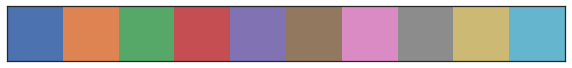

In [900]:
import math
import numpy as np
import numpy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from tqdm.notebook import tqdm
import scipy.stats as stats
from scipy import signal
pd.options.mode.chained_assignment = None
sns.set_palette(sns.color_palette('deep'))
plt.rcParams.update({'font.size': 12})
%matplotlib inline
# extra colors
# "#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3', '#937860', '#DA8BC3', '#8C8C8C', '#CCB974', '#64B5CD']
sns.palplot(sns.color_palette(colors))

### 1. Useful functions

In [866]:
# rename columns and exclude NaN given ET and HT X coordinates
def rename_clean(df):
    renamed_df = df.rename(columns={'xcoord':'ETWdirectionX','ycoord':'ETWdirectionY','zcoord':'ETWdirectionZ','xcoord_orig':'ETWoriginX','ycoord_orig':'ETWoriginY','zcoord_orig':'ETWoriginZ', 'xlocal_dir':'ETLdirectionX','ylocal_dir':'ETLdirectionY', 'zlocal_dir':'ETLdirectionZ', 'xhead':'HTdirectionX', 'yhead':'HTdirectionY', 'zhead':'HTdirectionZ', 'xhead_orig':'HToriginX', 'yhead_orig':'HToriginY','zhead_orig':'HToriginZ'})
    df_clean = renamed_df[renamed_df['ETWdirectionX'].notna() & renamed_df['xhpoo'].notna() & renamed_df['ETLdirectionX'].notna().reset_index(drop=True)]
    return df_clean

# Make all axes origins start from zero
def origins_from_zero(df):
    for col_name in df:
        # identify the origin axes
        if 'orig' in col_name:
            df[col_name] = df[col_name] - df[col_name].min()
    return df

# visualize ET and HT axes distribution
def vis_count_distr(df_clean, save=False, format='pdf', include_eye_local=False):
    """
    :param df_clean: df, a df without NaN
    :param safe: bool, specify if save image. False by default
    :param include_eye_local: local eye data coordinates
    :return: histogram image with ET and HT axes distributions
    """
    plot_subtitle="Axes behavioral distribution"
    img_title = "behavioral_distribution"
    # eye-tracking local distribution
    if include_eye_local:
        n_col = 3
        fig, ax = plt.subplots(2,n_col, figsize=(20, 12), sharey=True)
        fig.suptitle(plot_subtitle, fontsize=22, y=1)
        sns.histplot(df_clean[["ETLdirectionX", "ETLdirectionY","ETLdirectionZ"]], ax=ax[1,2])
        ax[1,2].set_xlabel('Range', size=14)
        ax[1,2].set_ylabel('Count', size=14)

        sns.histplot(df_clean[["ETLoriginX", "ETLoriginZ"]], ax=ax[0,2])
        ax[0,2].set_xlabel('Range', size=14)
        ax[0,2].set_ylabel('Count', size=14)
        col_title = ['Head', 'Eye world', 'Eye local']
    # "Head vs eye tracking behavioral data distributions"
    else:
        n_col = 2
        col_title = ['Head', 'Eye']
        fig, ax = plt.subplots(2,n_col, figsize=(20, 12))
    # head-tracking distribution
    fig.suptitle(plot_subtitle, fontsize=22, y=1)

    colors_or = dict(HToriginX=colors[3], HToriginY=colors[2], HToriginZ=colors[0])
    sns.histplot(df_clean[['HToriginX', 'HToriginZ']], palette=colors_or, alpha=0.7, ax=ax[0,0])
    ax[0,0].set_xlabel('Position (Unity space)', size=14)
    ax[0,0].set_ylabel('Count', size=14)
    ax[0,0].set_xlim(0,df_clean['HToriginX'].max())

    colors_dir = dict(HTdirectionX=colors[3], HTdirectionY=colors[2], HTdirectionZ=colors[0])
    sns.histplot(df_clean[['HTdirectionX', 'HTdirectionY', 'HTdirectionZ']], palette=colors_dir, alpha=0.7, ax=ax[1,0])
    ax[1,0].set_xlabel('Direction (Unity space)', size=14)
    ax[1,0].set_ylabel('Count', size=14)
    ax[1,0].set_xlim(-1,1)

    # eye-tracking world distribution
    colors_or_e = dict(ETWoriginX=colors[3], ETWoriginY=colors[2], ETWoriginZ=colors[0])
    sns.histplot(df_clean[["ETWoriginX", "ETWoriginZ"]], palette=colors_or_e, alpha=0.7, ax=ax[0,1])
    ax[0,1].set_xlabel('Position (Unity space)', size=14)
    ax[0,1].set_ylabel('', size=14)
    ax[0,1].set_xlim(0,df_clean['HToriginX'].max())

    colors_dir_e = dict(ETWdirectionX=colors[3], ETWdirectionY=colors[2], ETWdirectionZ=colors[0])
    sns.histplot(df_clean[["ETWdirectionX", "ETWdirectionY", "ETWdirectionZ"]], palette=colors_dir_e, alpha=0.7, ax=ax[1,1])
    ax[1,1].set_xlabel('Direction (Unity space)', size=14)
    ax[1,1].set_ylabel('', size=14)
    ax[1,1].set_xlim(-1,1)

    for i, ax in enumerate(ax.flatten()[:n_col]):
        ax.set_title(col_title[i], fontweight='bold', fontsize=16)
        i += 1
    img_title = img_title
    sns.despine(top=True)
    plt.tight_layout()
    if save:
        # Save visualization
        plt.savefig("../Images/new/"+img_title+"."+format, format=format, dpi=1200)

# visualize ET and HT axes' origin means
def vis_origin_mean(df, save=False, format='pdf'):
    suptitle="Origins' mean for X-Y-Z-axes"
    save_name="origin_mean"
    fig, ax = plt.subplots(2,2, figsize=(22,14))

    fig.suptitle(suptitle, fontsize=22, y=0.93)
    plt.rcParams.update({'font.size': 12})

    # mean distributions comparing head to eye tracing
    p1 = sns.violinplot(data=df[['HToriginX','ETWoriginX']], color =colors[3], ax=ax[0,0])
    ax[0,0].set_ylabel('Position (Unity space)', size=12)
    # sns.violinplot(data=df[['HToriginY', 'ETWoriginY']], ax=ax[0,1])
    # ax[0,1].set_ylabel('', size=12)
    p2 = sns.violinplot(data=df[['HToriginZ','ETWoriginZ']],color= colors[0], ax=ax[0,1])
    ax[0,1].set_ylabel('', size=12)

    p_list = [p1,p2]
    # different alpha per category
    for i, p in enumerate(p_list):
        for violin1, alpha in zip(p.collections[::2], [1,0.7]):
            violin1.set_alpha(alpha)

    # representation of the estimated central tendency where the error bars indicate the uncertainty around the estimate.
    sns.pointplot(data=df[['HToriginX','ETWoriginX']], capsize=.2, ax=ax[1,0])
    ax[1,0].set_ylabel('Position (Unity space)', size=12)
    # sns.pointplot(data=df[['HToriginY', 'ETWoriginY']],capsize=.2, ax=ax[1,1])
    # ax[1,1].set_ylabel('', size=12)
    sns.pointplot(data=df[['HToriginZ','ETWoriginZ']], capsize=.2, ax=ax[1,1])
    ax[1,1].set_ylabel('', size=12)
    sns.despine(top=True)
    if save:
        plt.savefig("../Images/newImages/"+save_name+"."+format, format=format, dpi=1200)

# visualize ET and HT axes' directions means
def vis_directions_mean(df, save=False, format='pdf'):
    suptitle="Directions' mean for X-Y-Z-axes"
    save_name="directions_mean"
    fig, ax = plt.subplots(2,3, figsize=(22,14))
    fig.suptitle(suptitle, fontsize=22, y=0.93)

    # mean distributions comparing head to eye tracing
    p1 = sns.violinplot(data=df[['HTdirectionX','ETWdirectionX']], color =colors[3], ax=ax[0,0])
    ax[0,0].set_ylabel('Direction (Unity space)', size=12)
    p2 = sns.violinplot(data=df[['HTdirectionY', 'ETWdirectionY']], color =colors[2], ax=ax[0,1])
    ax[0,1].set_ylabel('')
    p3 = sns.violinplot(data=df[['HTdirectionZ','ETWdirectionZ']], color =colors[0], ax=ax[0,2])
    ax[0,2].set_ylabel('')

    p_list = [p1,p2,p3]
    # different alpha per category
    for i, p in enumerate(p_list):
        for violin1, alpha in zip(p.collections[::2], [1,0.7]):
            violin1.set_alpha(alpha)

    # representation of the estimated central tendency where the error bars indicate the uncertainty around the estimate.
    sns.pointplot(data=df[['HTdirectionX','ETWdirectionX']], capsize=.2, ax=ax[1,0])
    ax[1,0].set_ylabel('Direction (Unity space)', size=12)
    sns.pointplot(data=df[['HTdirectionY', 'ETWdirectionY']],capsize=.2, ax=ax[1,1])
    ax[1,1].set_ylabel('')
    sns.pointplot(data=df[['HTdirectionZ','ETWdirectionZ']], capsize=.2, ax=ax[1,2])
    ax[1,2].set_ylabel('')
    sns.despine(top=True)
    if save:
        plt.savefig("../Images/new/"+save_name+"."+format, format=format, dpi=1200)

# ET and HT X-axis origin and directions through time
def vis_x_axis(df, id='',format='pdf', save=False):
    save_name="x_origin_direction_"
    subtitle="X-axis' origin and direction through time"

    fig, ax = plt.subplots(2,2, figsize=(22, 14), sharex=True)
    sns.set_palette(sns.color_palette('deep'))

    fig.suptitle(subtitle, fontsize=20, y=0.96)
    plt.rcParams.update({'font.size': 12})

    sns.lineplot(data=df[['HToriginX']], linewidth=2, ax=ax[0,0])
    ax[0,0].set_xlabel('Index/time', size=12)
    ax[0,0].set_ylabel('Range', size=14)
    ax[0,0].set(xlim=(0,None))

    sns.lineplot(data=df[['ETWoriginX']], linewidth=2, ax=ax[0,1])
    ax[0,1].set_xlabel('Index/Time', size=14)
    ax[0,1].set_ylabel('')
    ax[0,1].set(xlim=(0,None))

    sns.lineplot(data=df[['HTdirectionX']], linewidth=2, ax=ax[1,0])
    ax[1,0].set_xlabel('Index/Time', size=14)
    ax[1,0].set_ylabel('Range', size=14)
    ax[1,0].set(xlim=(0,None))

    sns.lineplot(data=df[['ETWdirectionX']], linewidth=2, ax=ax[1,1])
    ax[1,1].set_xlabel('Index/Time', size=14)
    ax[1,1].set_ylabel('')
    ax[1,1].set(xlim=(0,None))
    plt.legend(loc='upper right')
    sns.despine(top=True)

    col_title = ['Head', 'Eye']
    for i, ax in enumerate(ax.flatten()[:2]):
        ax.set_title(col_title[i], fontweight='bold', fontsize=16)
        i += 1
    if save:
        plt.savefig("../Images/new/"+save_name+id+"."+format, format=format, dpi=1200)
        # plt.savefig("../Images/new/"+save_name+id+".jpeg", format="jpeg", dpi=1200)


# ET vs. HT axes origin relation through time
def vis_origin_relational(df, sample=False, save=False, id='', format='pdf'):
    plt.rcParams.update({'font.size': 12})
    # sns.set_palette(sns.color_palette('deep'))
    # bahavioral axis relational distribution
    fig, ax = plt.subplots(3,1, figsize=(20, 12), sharex=True)

    if sample:
        n_sample=10000
        fig.suptitle("Axes' origins through index/time. Sample: " + str(n_sample), fontsize=22)
        sns.lineplot(data=df[['HToriginX','ETWoriginX']].head(n_sample), linewidth=2, legend=True, ax=ax[0])
        ax[0].set_xlabel('')
        ax[0].set_ylabel('Origin X', size=14)
        ax[0].set(xlim=(0,None))
        sns.lineplot(data=df[['HToriginY', 'ETWoriginY']].head(n_sample), linewidth=2,legend=True, ax=ax[1])
        ax[1].set_xlabel('')
        ax[1].set_ylabel('Origin Y', size=14)
        # ax[1].set_ylim(None, 2.15)
        ax[1].set(xlim=(0,None))
        sns.lineplot(data=df[['HToriginZ', 'ETWoriginZ']].head(n_sample), linewidth=2,legend=True, ax=ax[2])
        ax[2].set_xlabel('Index/Time', size=14)
        ax[2].set_ylabel('Origin Z', size=14)
        ax[2].set(xlim=(0,None))

    else:
        n_sample="all"
        fig.suptitle("Axes' origins through index/time. Sample: all", fontsize=22)
        sns.lineplot(data=df[['HToriginX','ETWoriginX']], linewidth=2, legend=True,ax=ax[0])
        ax[0].set_xlabel('')
        ax[0].set_ylabel('Origin X', size=14)
        ax[0].set(xlim=(0,None))
        sns.lineplot(data=df[['HToriginY', 'ETWoriginY']], linewidth=2,legend=True, ax=ax[1])
        ax[1].set_xlabel('')
        ax[1].set_ylabel('Origin Y', size=14)
        ax[1].set_ylim(None, 2.15)
        ax[1].set(xlim=(0,None))
        sns.lineplot(data=df[['HToriginZ', 'ETWoriginZ']], linewidth=2, legend=True,ax=ax[2])
        ax[2].set_xlabel('Index/Time', size=14)
        ax[2].set_ylabel('Origin Z', size=14)
        ax[2].set(xlim=(0,None))
    fig.subplots_adjust(hspace=0.4)
    sns.despine(top=True)
    if save:
        plt.savefig("..Images/new/"+"axis_origin_relational_"+ str(n_sample)+"_"+id+"."+format, format=format, dpi=1200)

# ET vs. HT axes directions relation through time
def vis_direction_relational(df, sample=False, save=False, id='', format='pdf'):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(3,1, figsize=(20, 12))
    # sns.set_palette(sns.color_palette('deep'))

    if sample:
        n_sample=10000
        fig.suptitle("Axes' directions through time. Sample: " + str(n_sample), fontsize=22, y=0.93)
        sns.lineplot(data=df[['HTdirectionX','ETWdirectionX']].head(n_sample), linewidth=2, ax=ax[0])
        ax[0].set_xlabel('')
        ax[0].set_ylabel('Direction X', size=14)
        ax[0].set(xlim=(0,None))
        sns.lineplot(data=df[['HTdirectionY', 'ETWdirectionY']].head(n_sample), linewidth=2, ax=ax[1])
        ax[1].set_xlabel('')
        ax[1].set_ylabel('Direction Y', size=14)
        ax[1].set(xlim=(0,None))
        ax[1].set(ylim=(-0.8, 0.8))
        sns.lineplot(data=df[['HTdirectionZ', 'ETWdirectionZ']].head(n_sample), linewidth=2, ax=ax[2])
        ax[2].set_xlabel('Index/Time', size=14)
        ax[2].set_ylabel('Direction Z', size=14)
        ax[2].set(xlim=(0,None))

    else:
        n_sample="all"
        fig.suptitle("Axes' directions through time. Sample: all ", fontsize=22, y=0.93)
        sns.lineplot(data=df[['HTdirectionX','ETWdirectionX']], linewidth=2, ax=ax[0])
        ax[0].set_xlabel('')
        ax[0].set_ylabel('Direction X', size=14)
        ax[0].set(xlim=(0,None))
        sns.lineplot(data=df[['HTdirectionY', 'ETWdirectionY']], linewidth=2, ax=ax[1])
        ax[1].set_xlabel('')
        ax[1].set_ylabel('Direction Y', size=14)
        ax[1].set(xlim=(0,None))
        ax[1].set(ylim=(-0.8, 0.8))
        sns.lineplot(data=df[['HTdirectionY', 'ETWdirectionY']], linewidth=2, ax=ax[2])
        ax[2].set_xlabel('Index/Time', size=14)
        ax[2].set_ylabel('Direction Z', size=14)
        ax[2].set(xlim=(0,None))
    fig.subplots_adjust(hspace=0.4)
    sns.despine(top=True)
    if save:
        # plt.savefig("Images/" + "head_vs_eye_axis_direction" + str(n_sample) + ".pdf", format='pdf', dpi=1200)
        plt.savefig("../Images/new/"+"axis_direction_relational_"+ str(n_sample)+"_"+id+"."+format, format=format, dpi=1200)

## 2. Upload data

In [47]:
os.chdir("../Data/")
file_extension = ".csv"
all_filenames = [i for i in glob.glob(f"*{file_extension}")]
all_filenames

['correTS_c924cc42-5987-4025-b026-c672e304599f.csv',
 'correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c.csv',
 'correTS_1dea5bd2-80d1-4068-b512-99c55f85f44c.csv',
 'correTS_02715e7a-5a68-471b-9e63-f056c5f0df81.csv']

# 3. ET vs HT axes origins and directions through time (fps)

  0%|          | 0/4 [00:00<?, ?it/s]

Visualizing ID: correTS_c924cc42-5987-4025-b026-c672e304599f


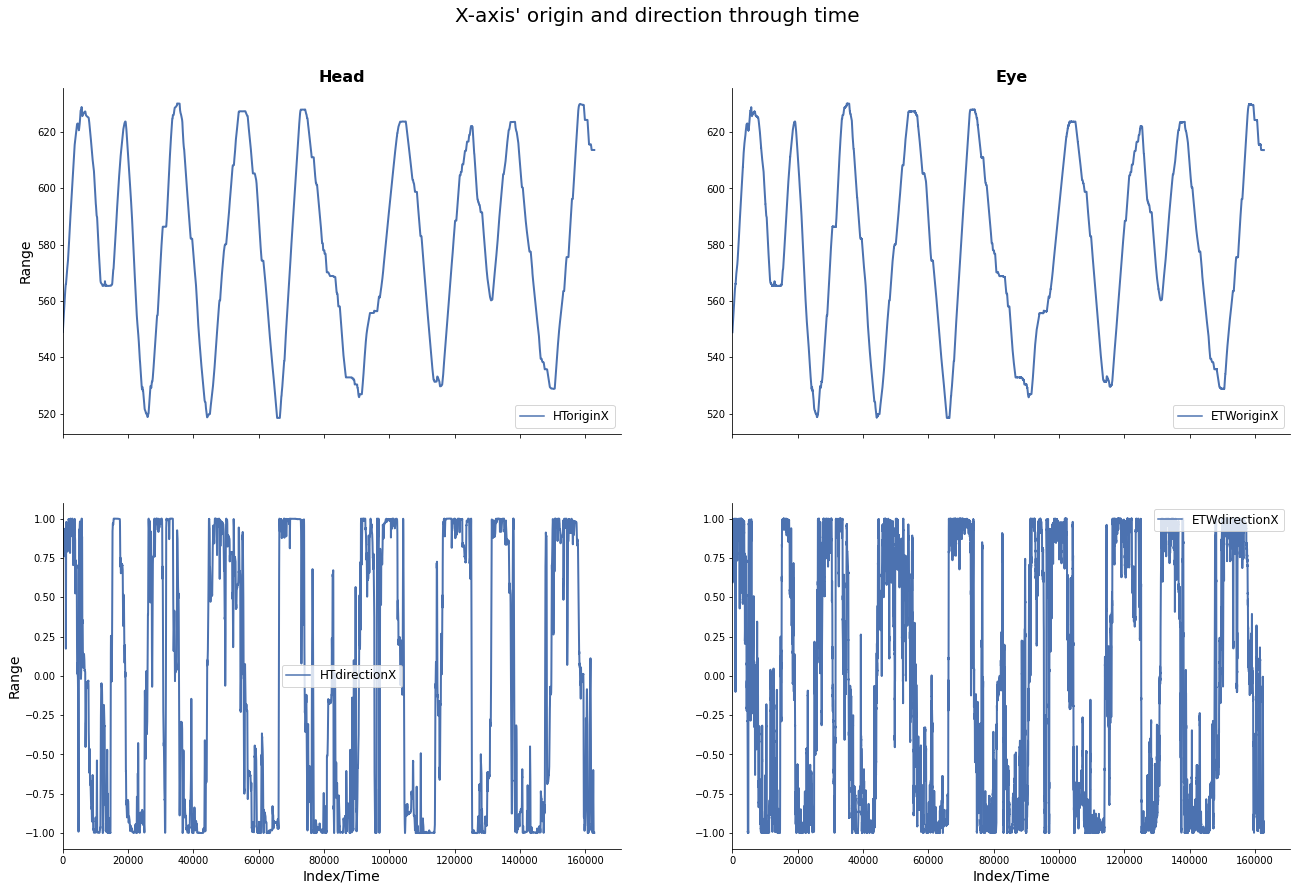

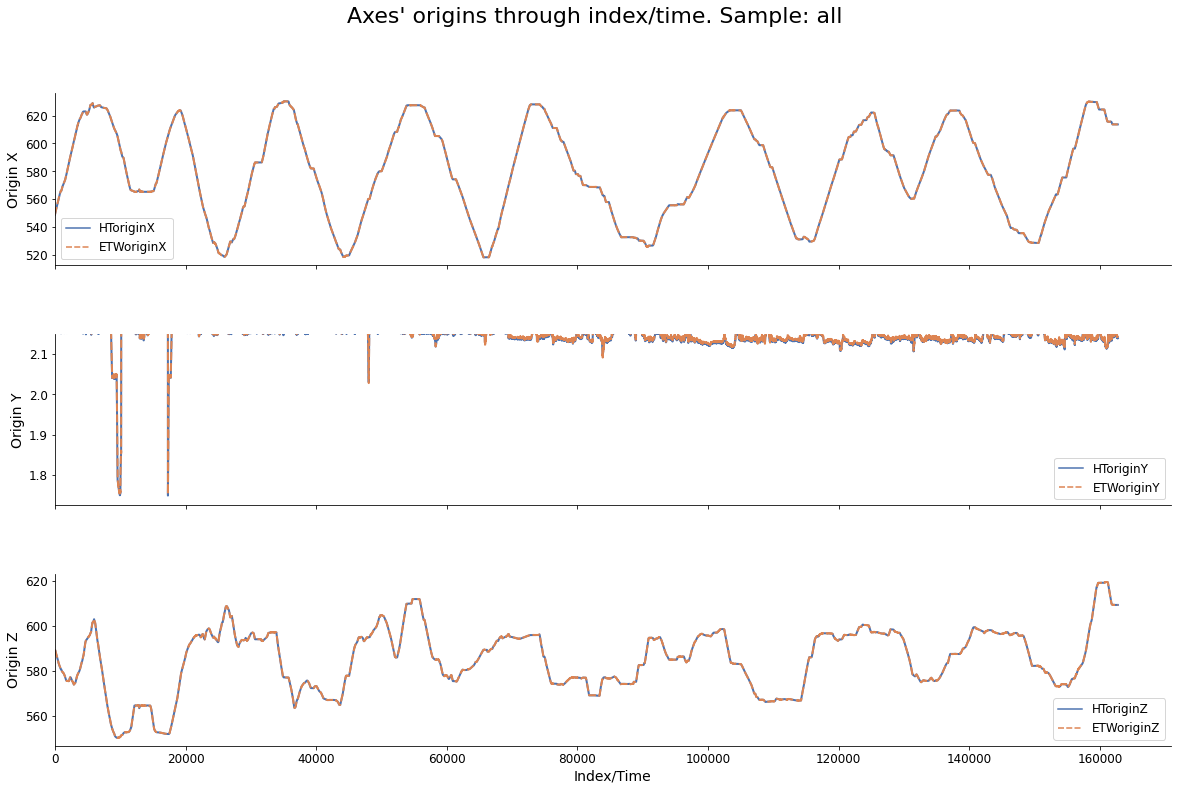

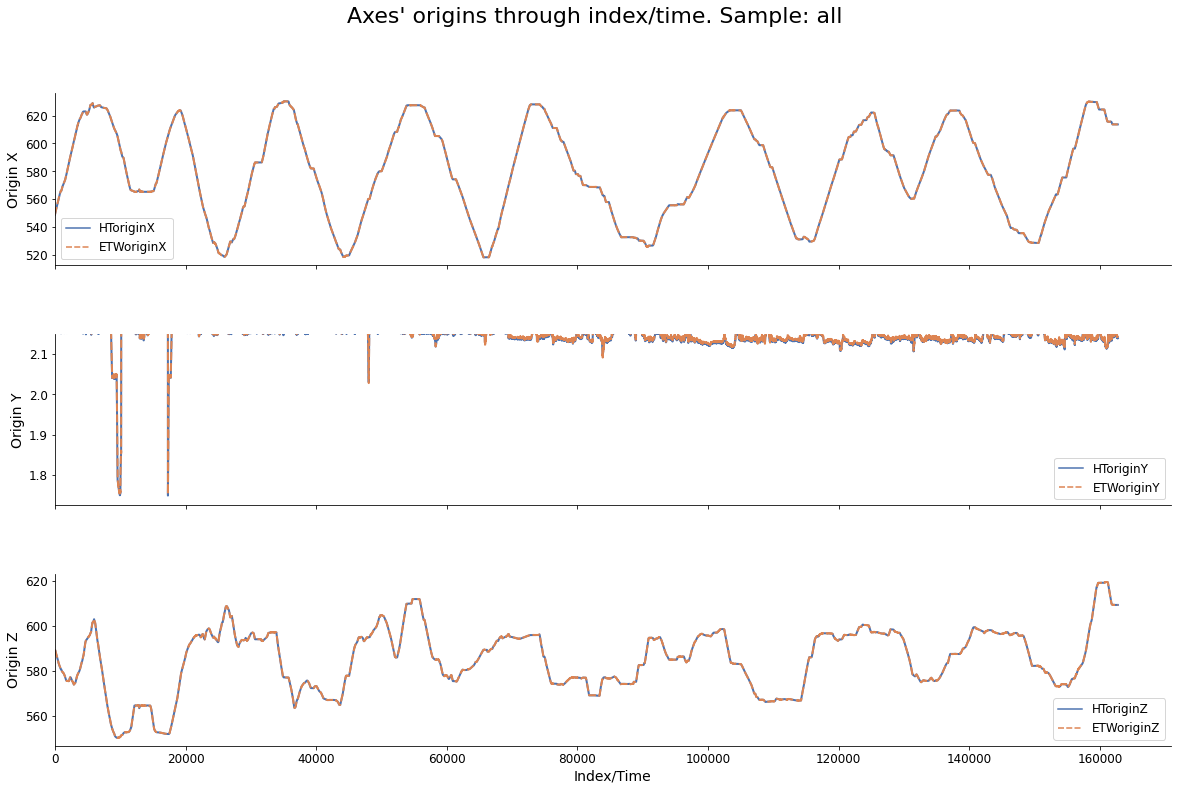

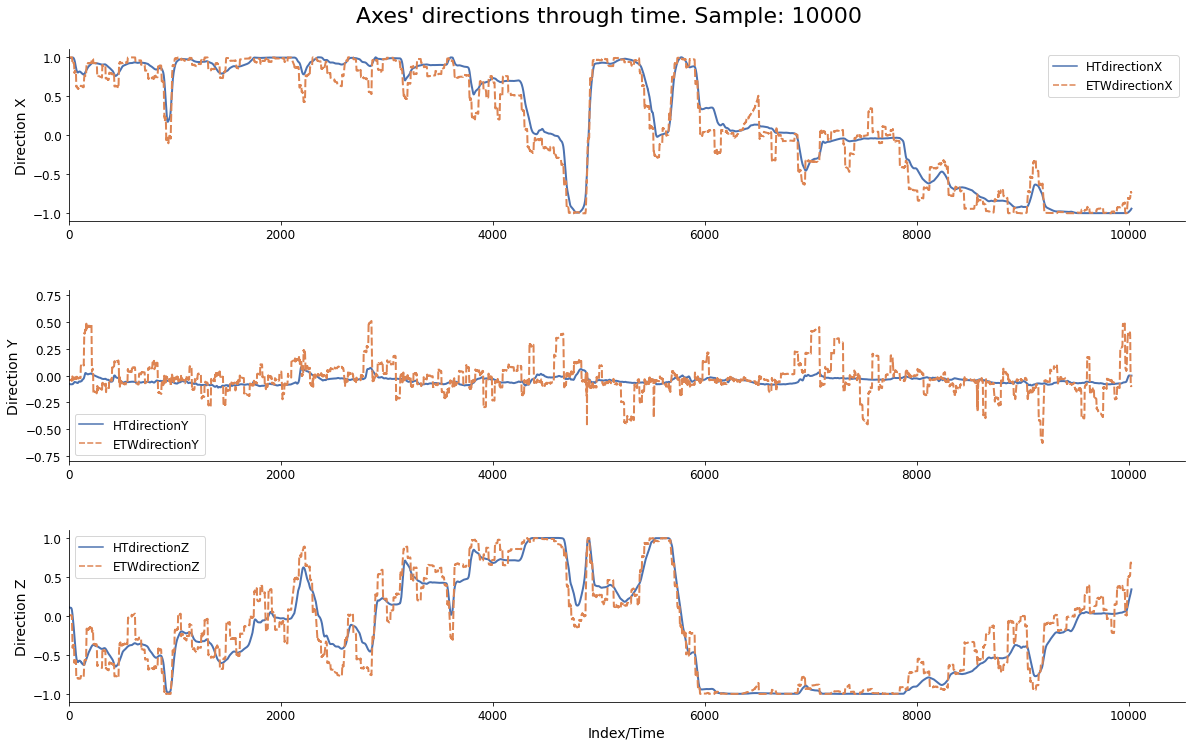

Visualizing ID: correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c


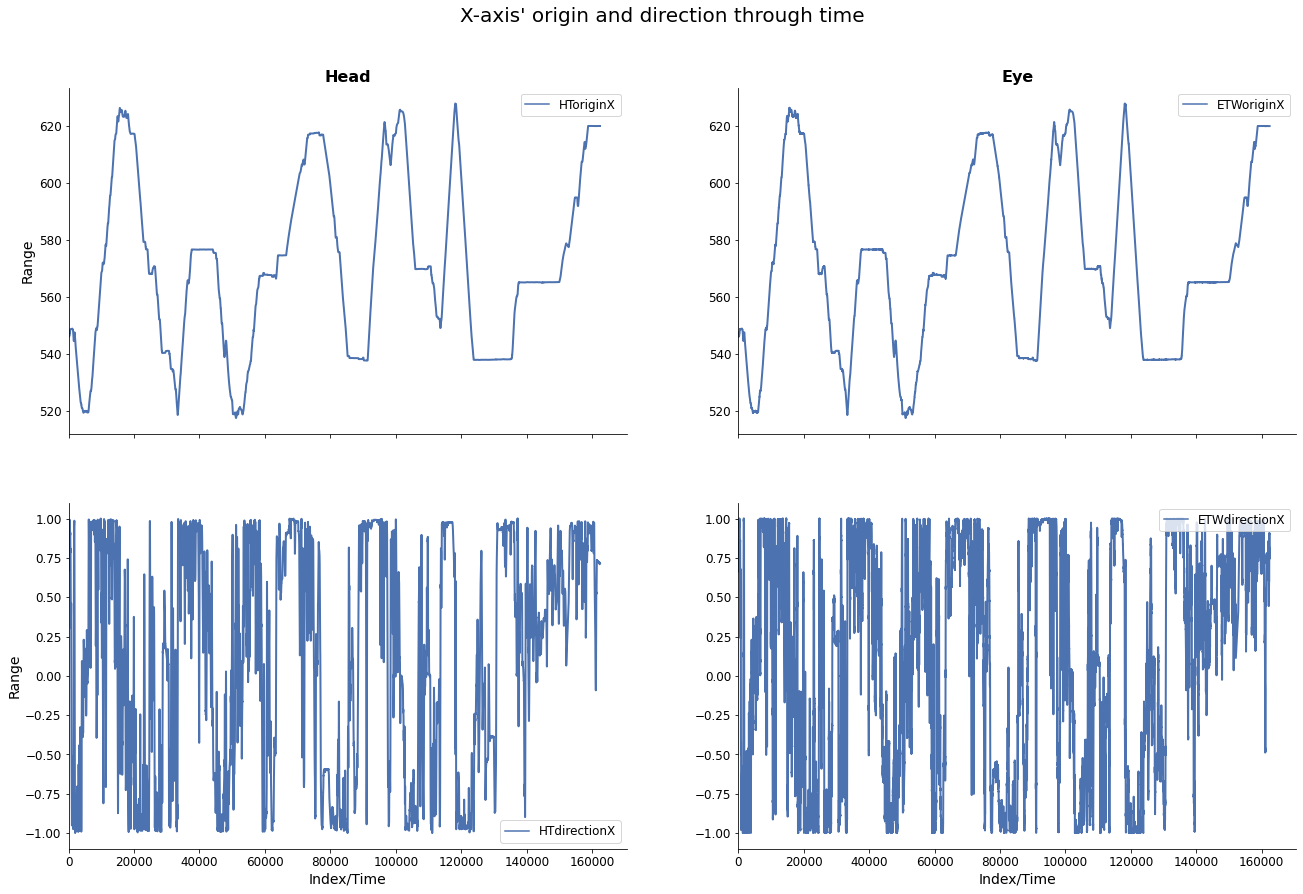

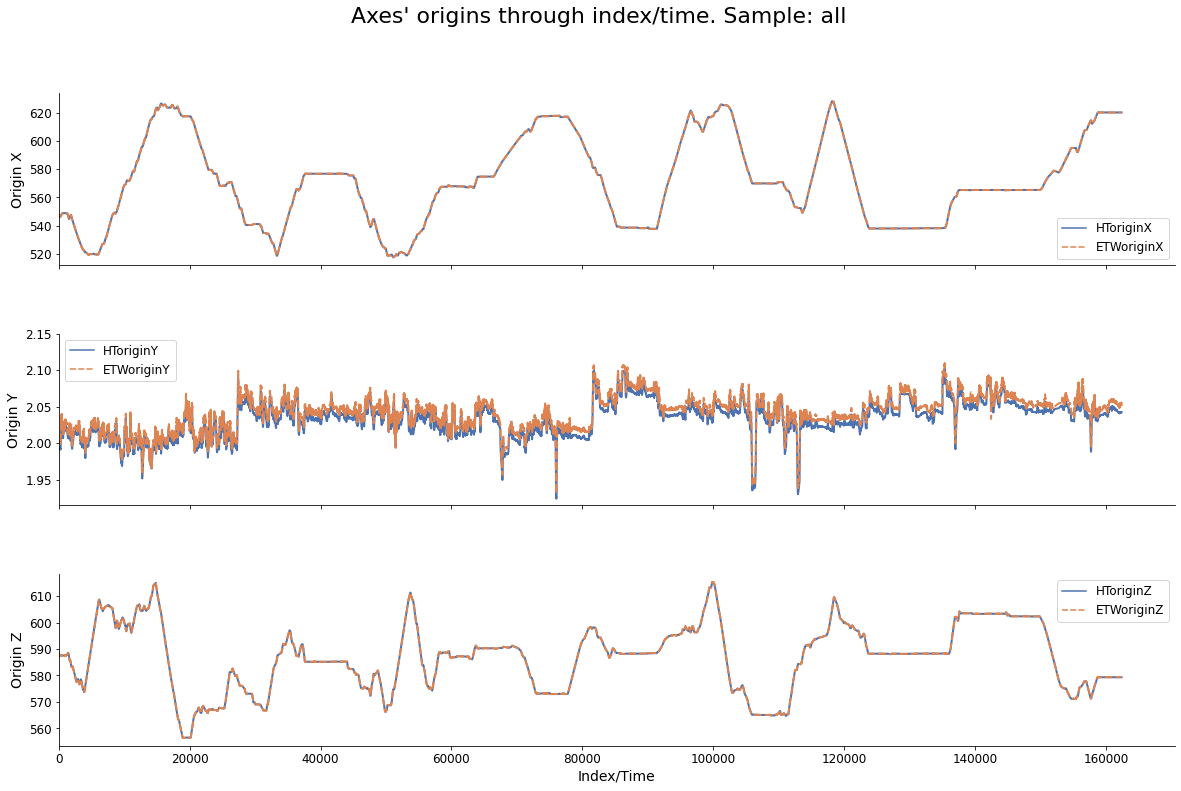

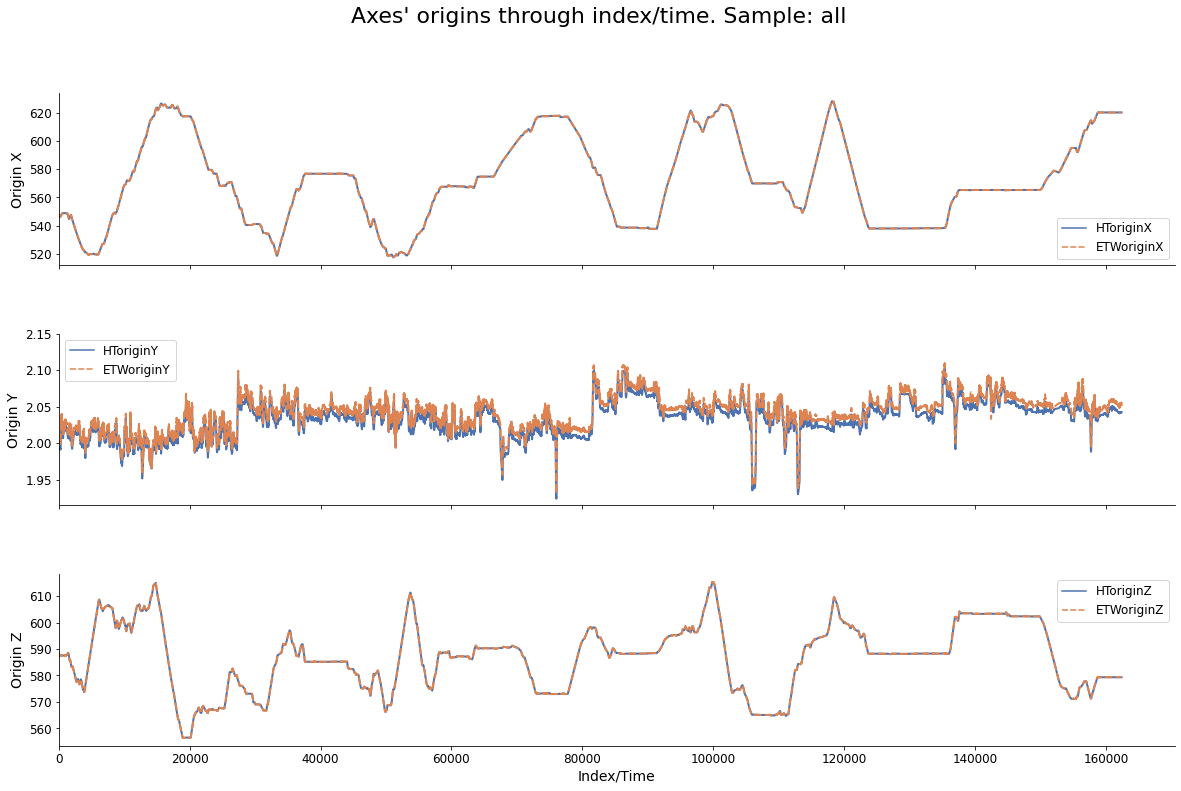

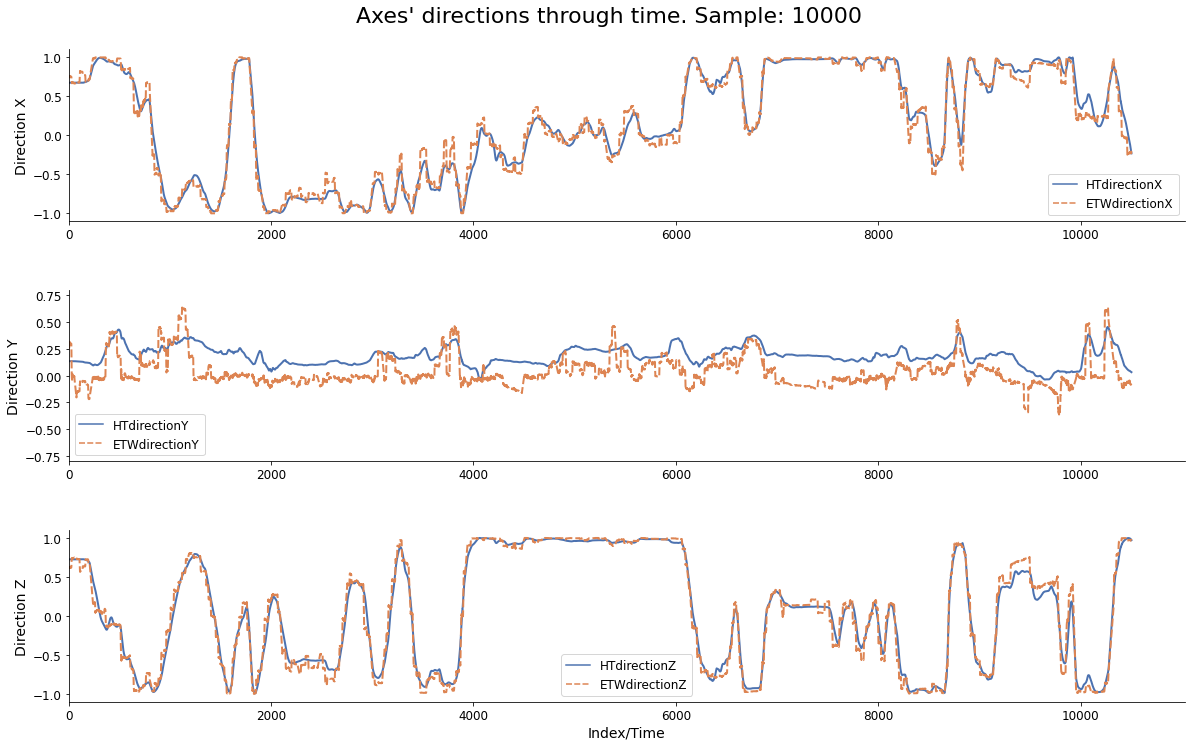

Visualizing ID: correTS_1dea5bd2-80d1-4068-b512-99c55f85f44c


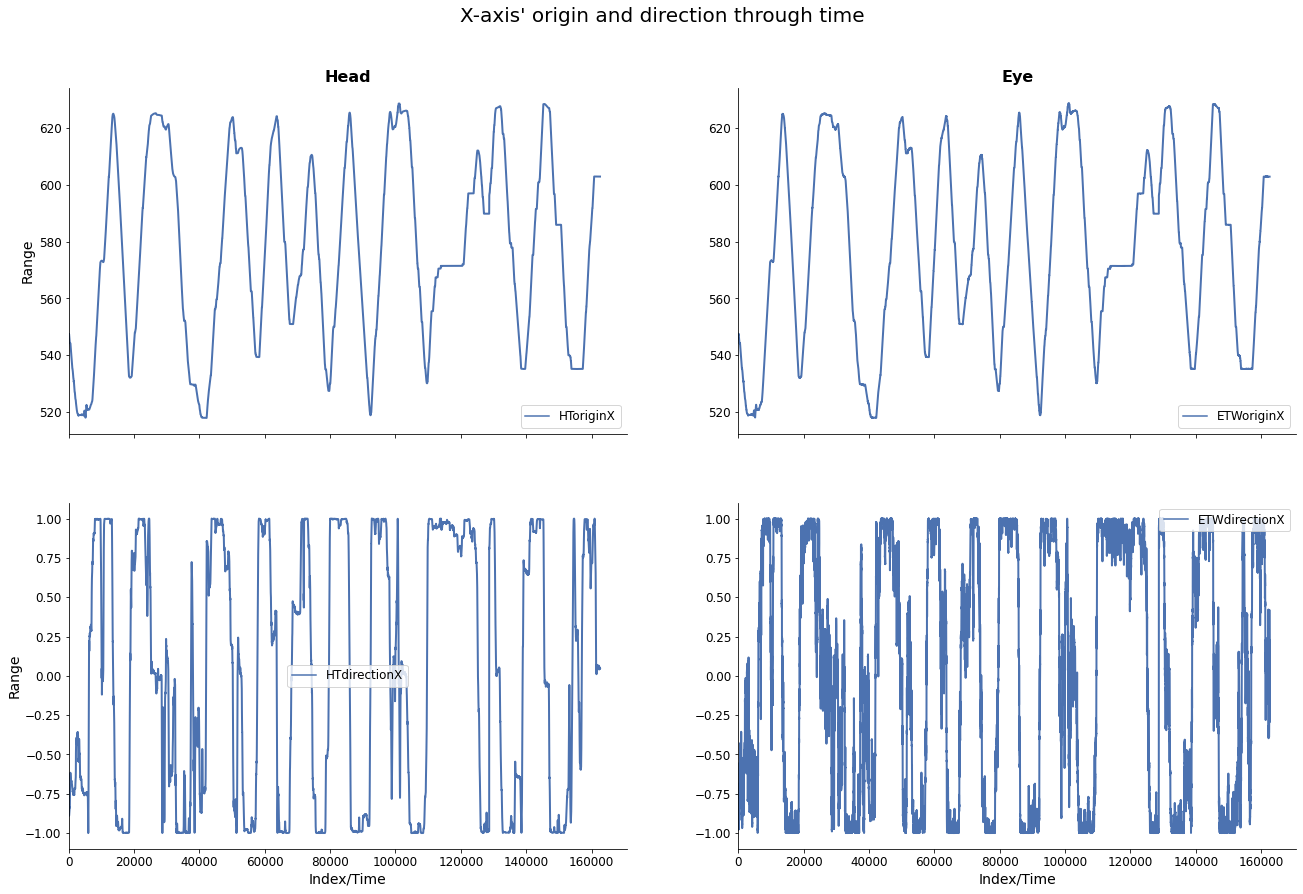

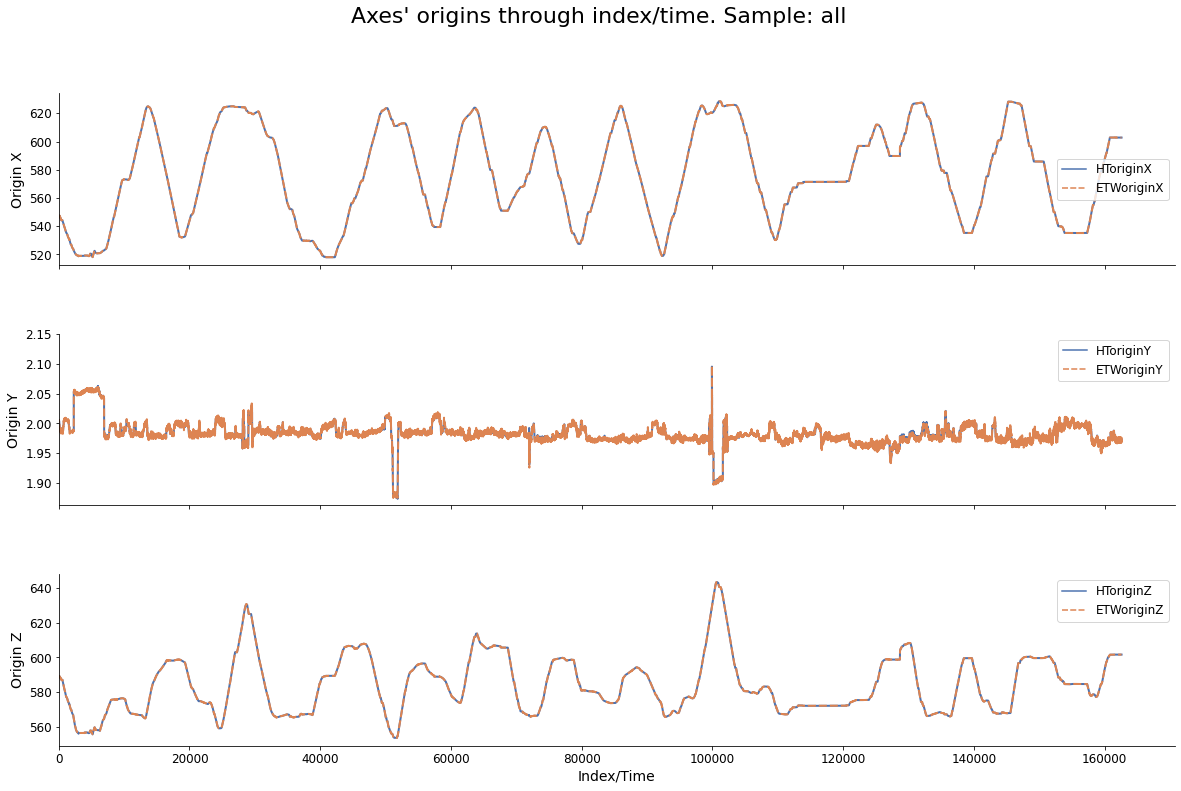

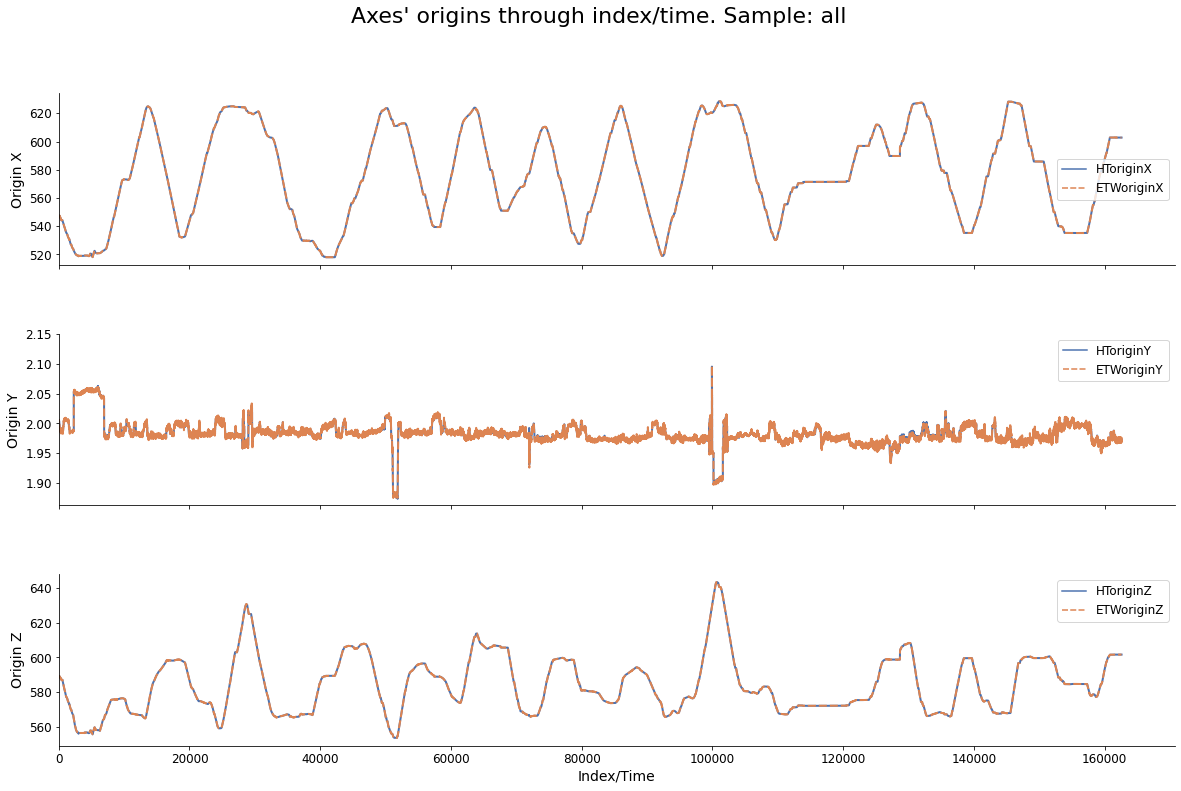

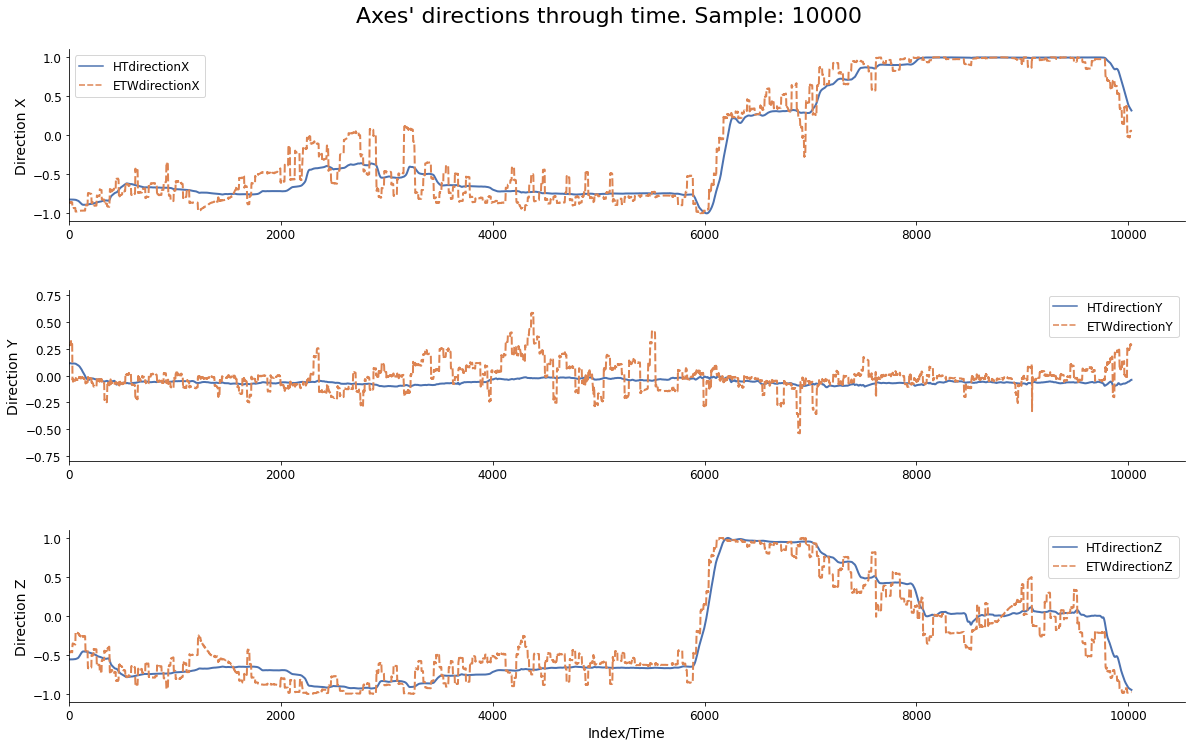

Visualizing ID: correTS_02715e7a-5a68-471b-9e63-f056c5f0df81


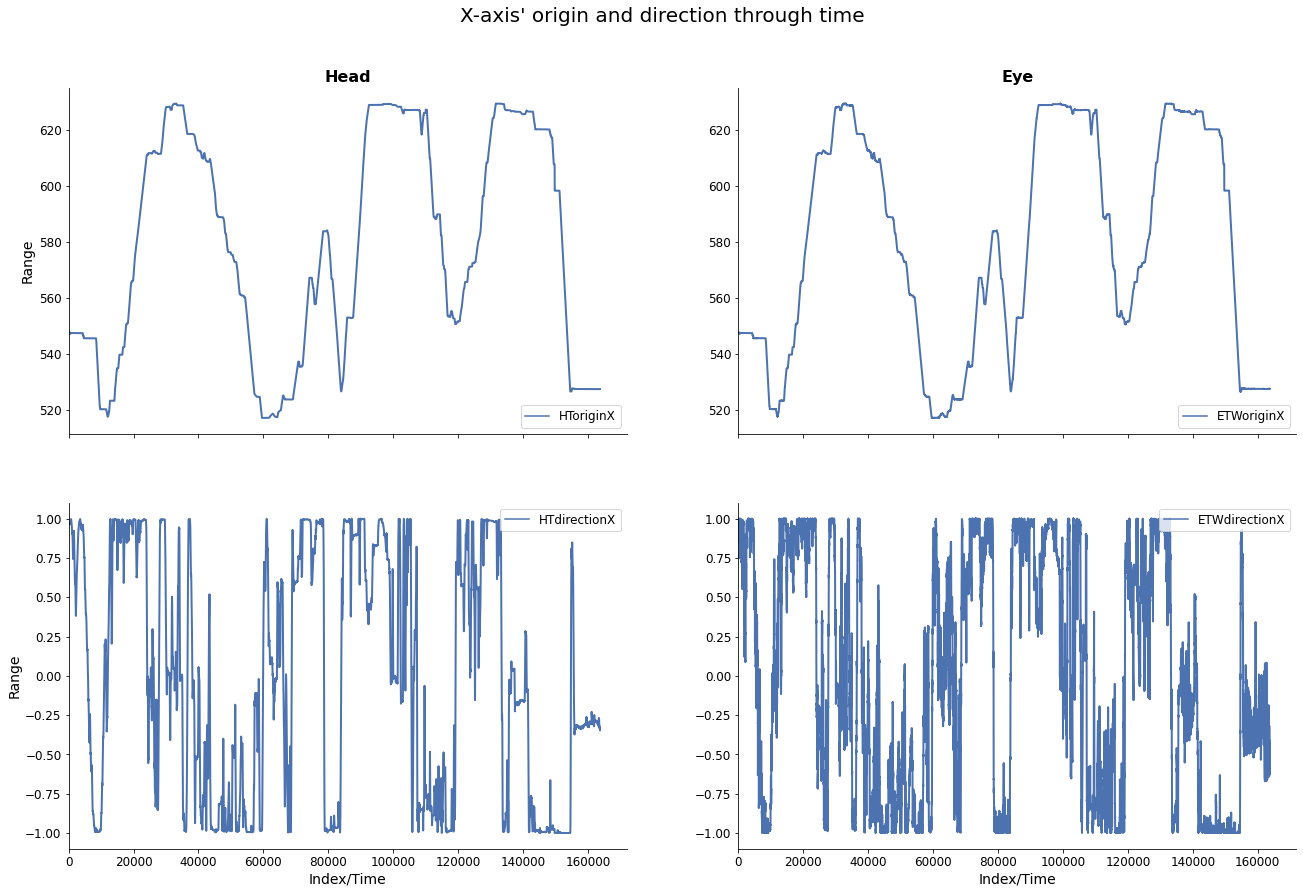

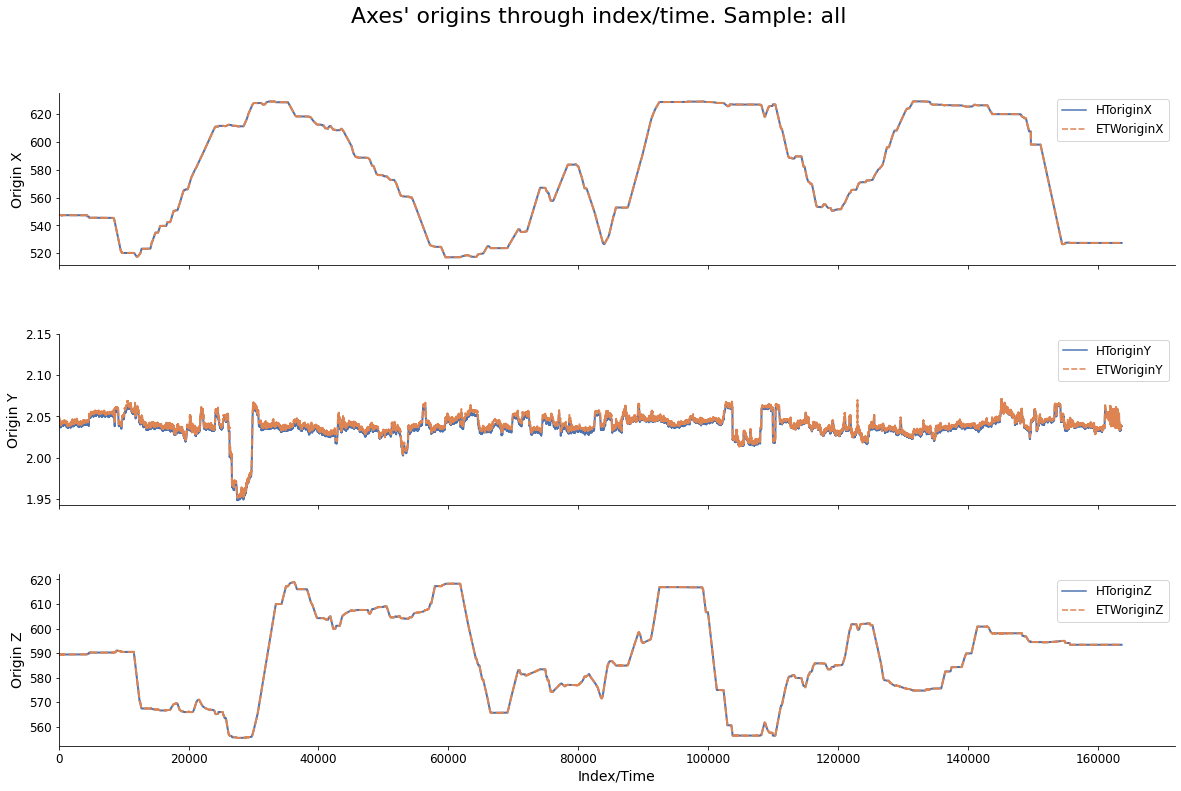

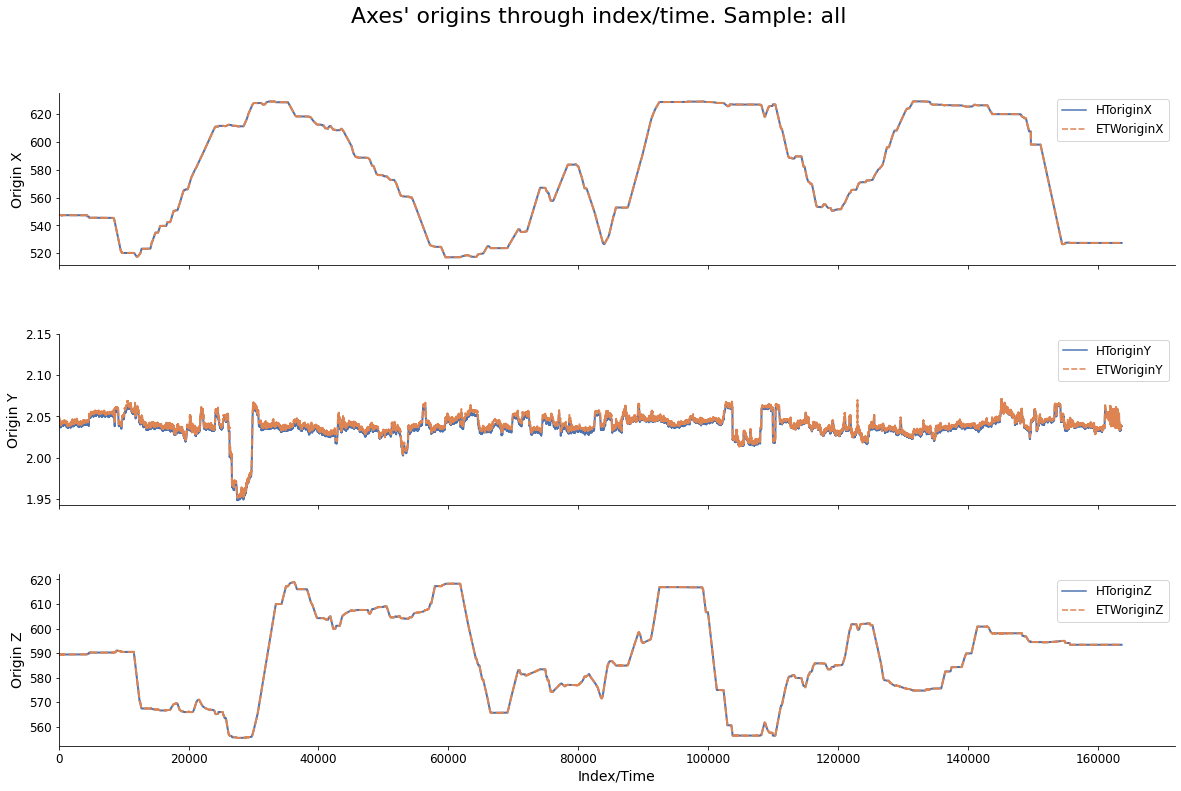

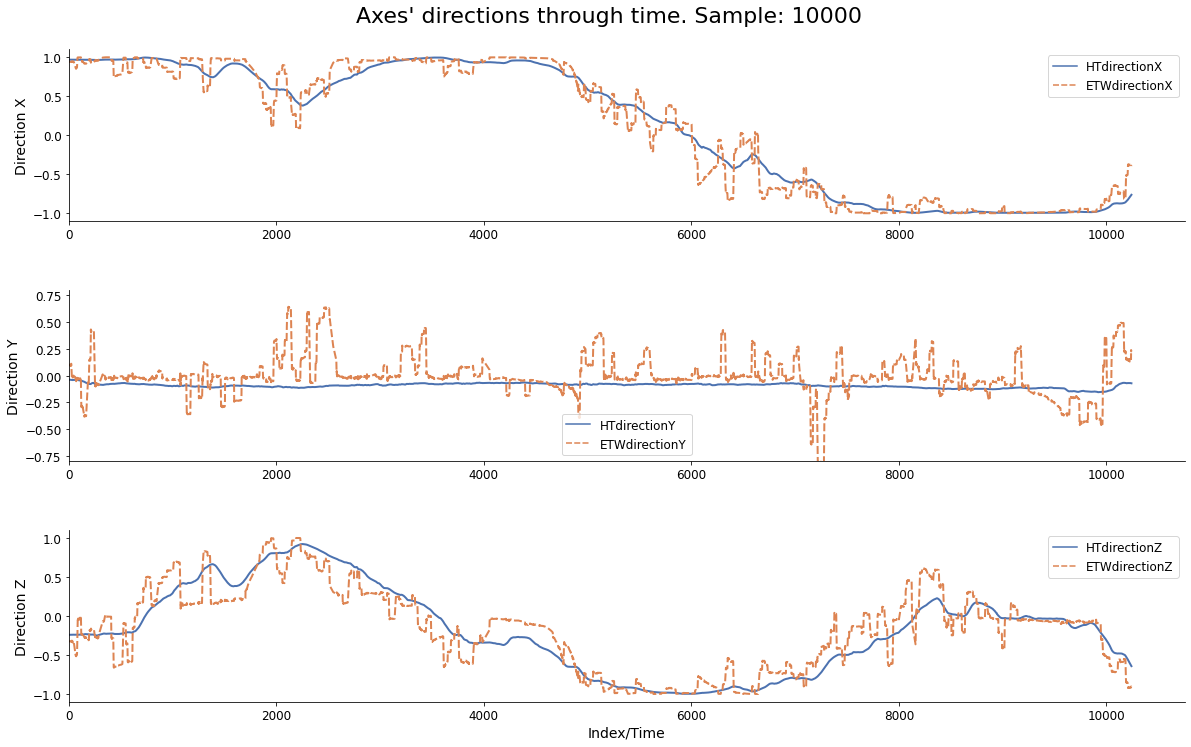

In [6]:
# visualize all files individually
for file in tqdm(all_filenames):
    fileID = file.split('.')
    print(f"Visualizing ID: " + fileID[0])
    df = pd.read_csv(file)
    df_clean = rename_clean(df)
    # origins and directions for x-axis
    vis_x_axis(df_clean, id=str(fileID[0]),format='pdf', save=False)
    # origins for all axes and 10000 samples
    vis_origin_relational(df_clean, save=False, id=str(fileID[0]), format='pdf')
    vis_origin_relational(df_clean, save=False, id=str(fileID[0]), format='pdf')
    # directions for all axes for 10000 sample
    vis_direction_relational(df_clean, save=False, sample=True)
    plt.show()

### 3.1 Mean origin and directions

In [451]:
# concatenate all data
df = rename_clean(pd.concat([pd.read_csv(file, delimiter=',') for file in all_filenames], ignore_index=True))
df

Unnamed: 0      time  ETWdirectionX  ETWdirectionY  ETWdirectionZ  \
0                0     0.000       0.999250      -0.047041       0.015843   
1                1     0.011       0.999445      -0.041306       0.012150   
2                2     0.022       0.999470      -0.040301       0.011573   
3                3     0.033       0.999484      -0.039621       0.011871   
4                4     0.044       0.999510      -0.038649       0.011454   
...            ...       ...            ...            ...            ...   
651361      163651  2806.947      -0.465525       0.053999      -0.884111   
651362      163652  2806.958      -0.466018       0.055140      -0.883809   
651363      163653  2806.969      -0.388782       0.076406      -0.919556   
651364      163654  2806.980      -0.349532       0.084078      -0.934805   
651365      163655  2806.992      -0.322776       0.063792      -0.945271   

        ETWoriginX  ETWoriginY  ETWoriginZ  ETLdirectionX  ETLdirectionY  ...  \
0        548.94037    2.159098   589.13130       0.097641       0.043488  ...   
1        548.96930    2.159502   589.10960       0.100937       0.047668  ...   
2        548.99414    2.159547   589.10960       0.101166       0.048355  ...   
3        549.01850    2.159583   589.10986       0.100540       0.048767  ...   
4        549.04280    2.159638   589.11170       0.100677       0.049408  ...   
...            ...         ...         ...            ...            ...  ...   
651361   527.39570    2.039758   593.38170       0.140884       0.020569  ...   
651362   527.39575    2.039808   593.38184       0.140656       0.021255  ...   
651363   527.39570    2.040012   593.38245       0.054550       0.033539  ...   
651364   527.39500    2.039536   593.38130       0.011353       0.037384  ...   
651365   527.39465    2.039790   593.38210      -0.017776       0.020844  ...   

        HT_thresh     isFix   HT_isFix  corrected_vel  events   length  \
0       28.365312       NaN        NaN            NaN     NaN      NaN   
1       28.365312  0.000000   0.000000       0.000000     2.0    0.322   
2       28.365312  6.303690  11.528232       6.303690     NaN    0.322   
3       28.365312  4.087432   8.864901       4.087432     NaN    0.322   
4       28.365312  5.608021   8.513613       5.608021     NaN    0.322   
...           ...       ...        ...            ...     ...      ...   
651361   0.000000       NaN        NaN       4.283954     NaN  607.163   
651362   0.000000       NaN        NaN       6.674671     NaN  607.163   
651363   0.000000       NaN        NaN     379.524815     NaN  607.163   
651364   0.000000       NaN        NaN     199.927169     NaN  607.163   
651365   0.000000       NaN        NaN     154.831190    -1.0  607.163   

         distance   avg_dist              names  long_events  
0             NaN        NaN                NaN          NaN  
1       21.942207  21.511931  Sitting_NPC (424)     0.822879  
2       21.865347  21.511931  Sitting_NPC (424)     0.822879  
3       21.853582  21.511931  Sitting_NPC (424)     0.822879  
4       21.806578  21.511931  Sitting_NPC (424)     0.822879  
...           ...        ...                ...          ...  
651361  44.399606  35.865583            Terrain          NaN  
651362  44.353795  35.865583            Terrain          NaN  
651363  53.198043  35.865583            Terrain          NaN  
651364  59.185550  35.865583            Terrain          NaN  
651365  64.048549  35.865583            Terrain          NaN  

[630120 rows x 39 columns]

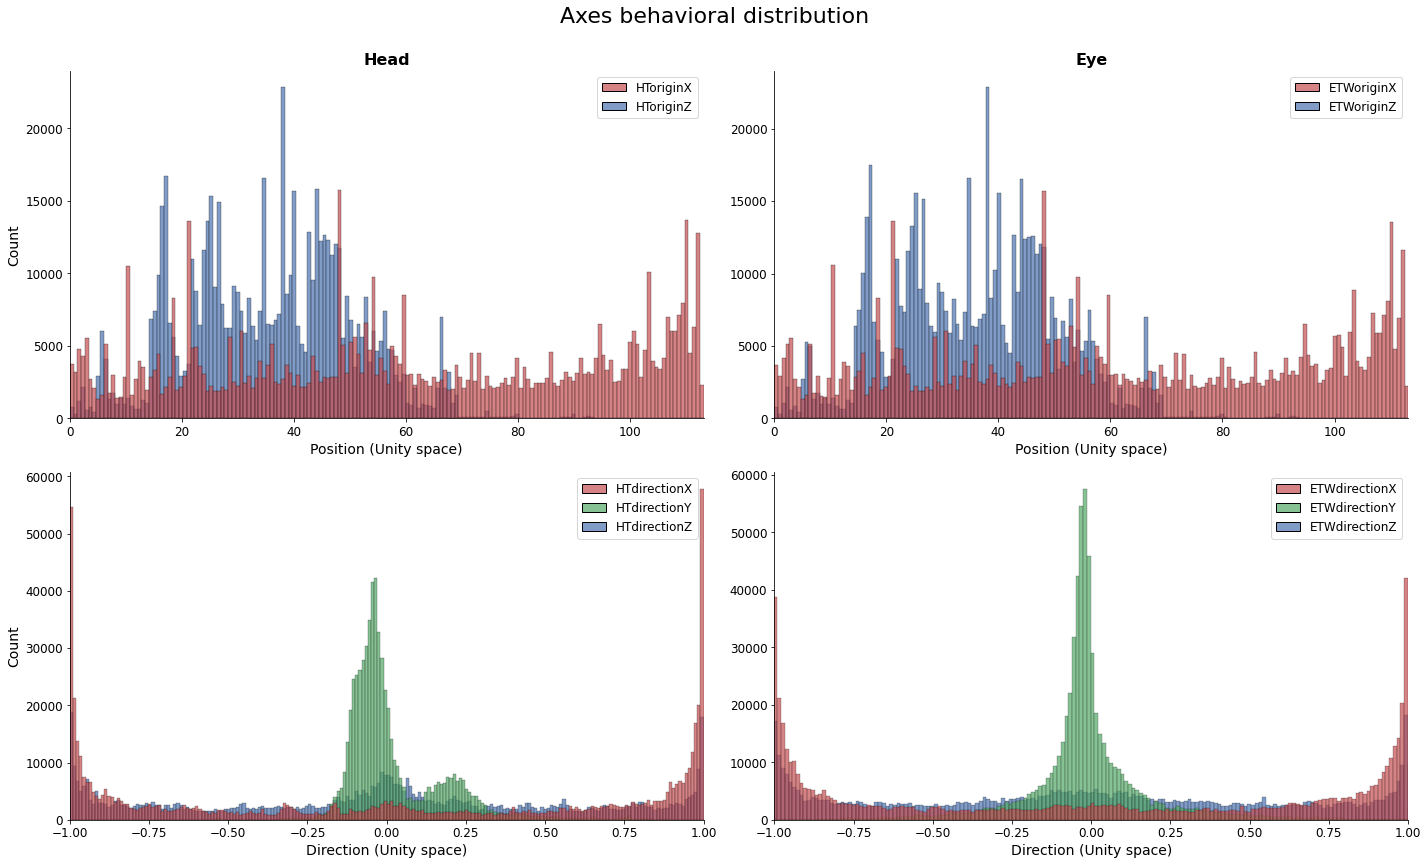

In [452]:
# origins and directions distribution
# normalize origins to start from zero
df_origins =  origins_from_zero(df)
# the Y-axis was excluded since it remains invariant; subjects are sitting on a spinning chair
vis_count_distr(df_origins, include_eye_local=False, save=False)

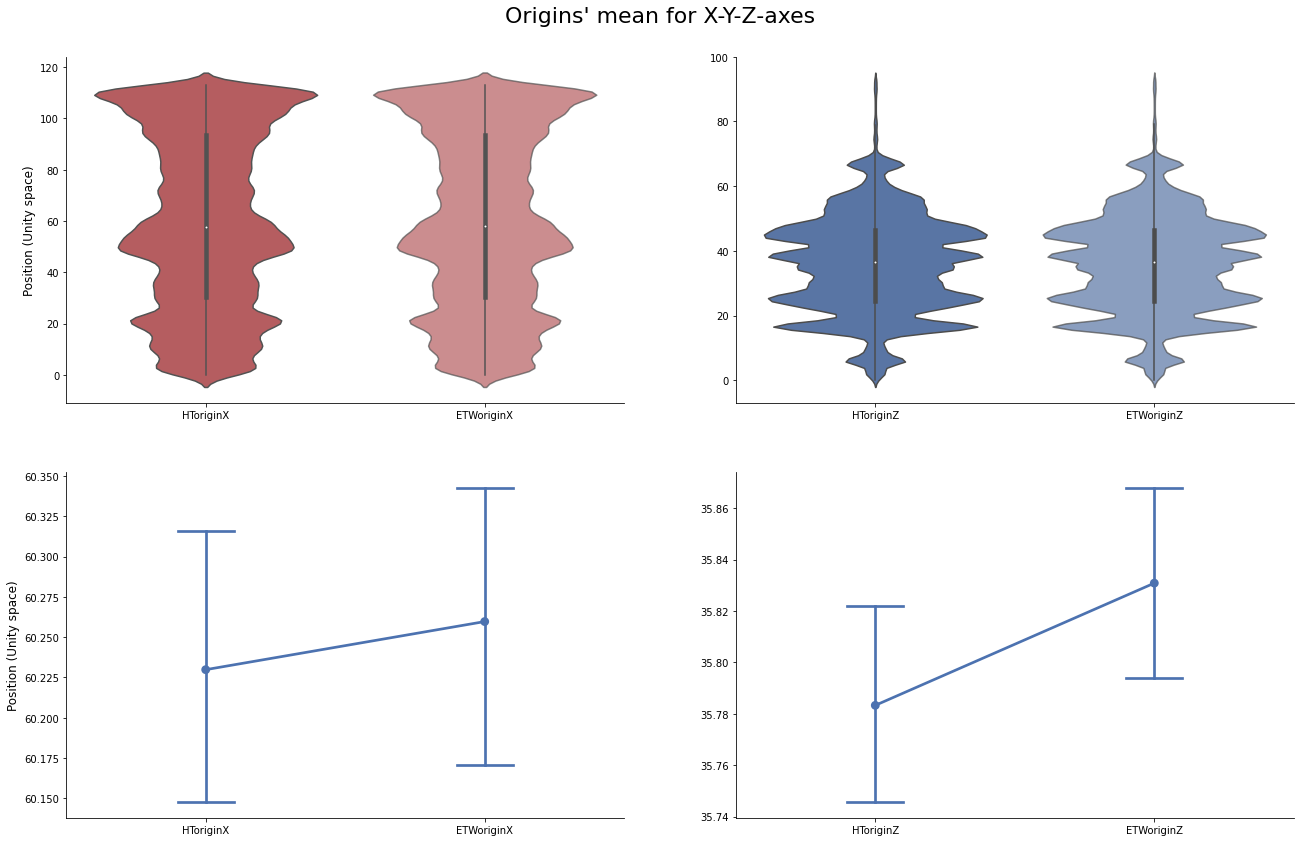

In [351]:
vis_origin_mean(df_origins)

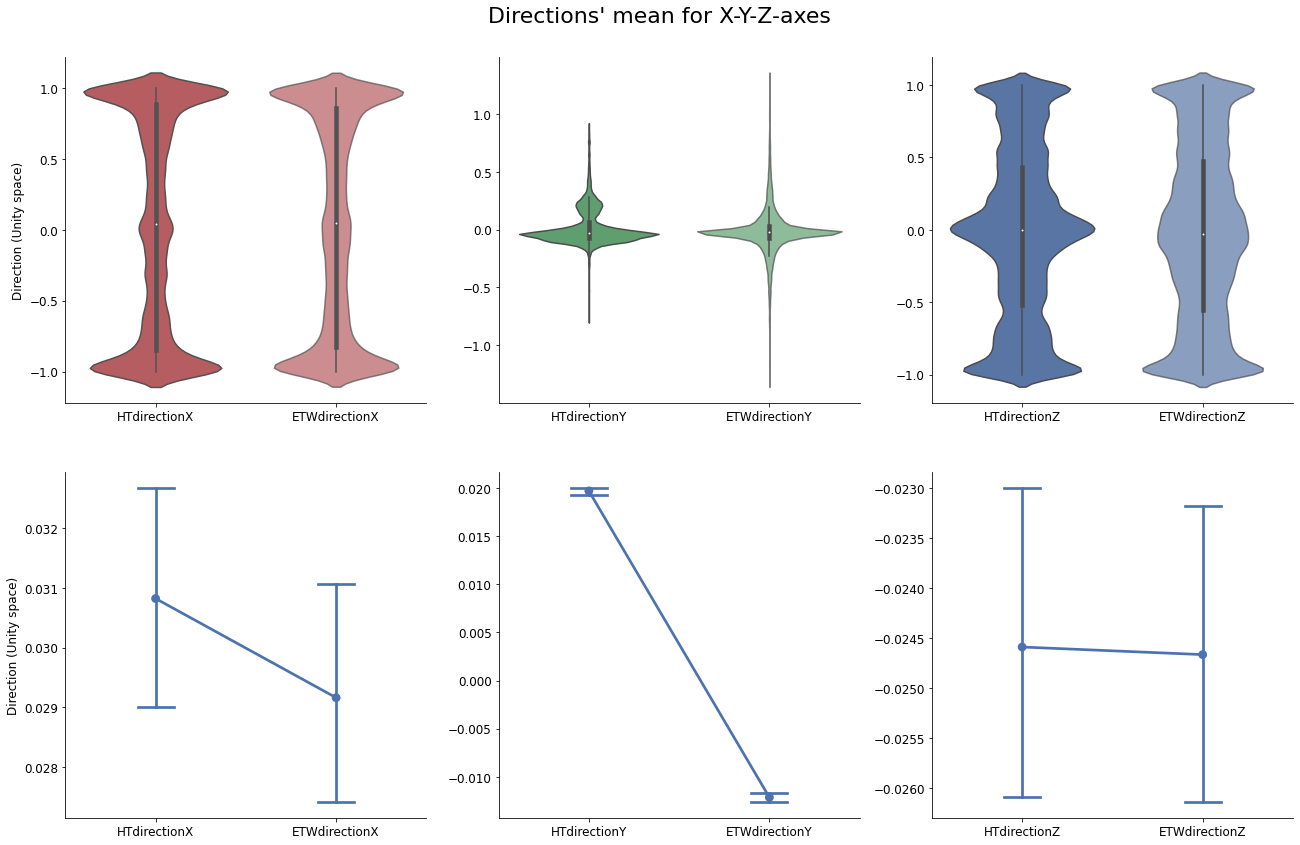

In [384]:
vis_directions_mean(df_origins)

In [651]:
# df does not contain nan
df_origins.isna().sum()

Unnamed: 0              0
time                    0
ETWdirectionX           0
ETWdirectionY           0
ETWdirectionZ           0
ETWoriginX              0
ETWoriginY              0
ETWoriginZ              0
ETLdirectionX           0
ETLdirectionY           0
ETLdirectionZ           0
HTdirectionX            0
HTdirectionY            0
HTdirectionZ            0
HToriginX               0
HToriginY               0
HToriginZ               0
xhpoo                   0
yhpoo                   0
zhpoo                   0
hon                561684
hon_all             20244
xhop               468089
yhop               468089
zhop               468089
blinks                  0
combined_vel          571
HT_combined_vel       473
thresh                  2
HT_thresh               2
isFix              234362
HT_isFix           146413
corrected_vel       75170
events             558410
length                  4
distance                4
avg_dist                4
names               26246
long_events 

### 3.2 Calculating correlation coefficient


In [630]:
# functions to calculate and annotate axes coefficients
def corr_coefficient(df, x='',y=''):
    # choose coefficient method (spearman or pearson)
    r, p = stats.pearsonr(df[x],df[y])
    return r, p
def annotate_rp(x,r,p):
    x.ax_joint.annotate(f'r = {r:.3f}, p = {p:.3f}',
            xy=(0.1, 0.9), xycoords='axes fraction',
            ha='left', va='center',
            bbox={'boxstyle': 'round', 'fc': 'white'})

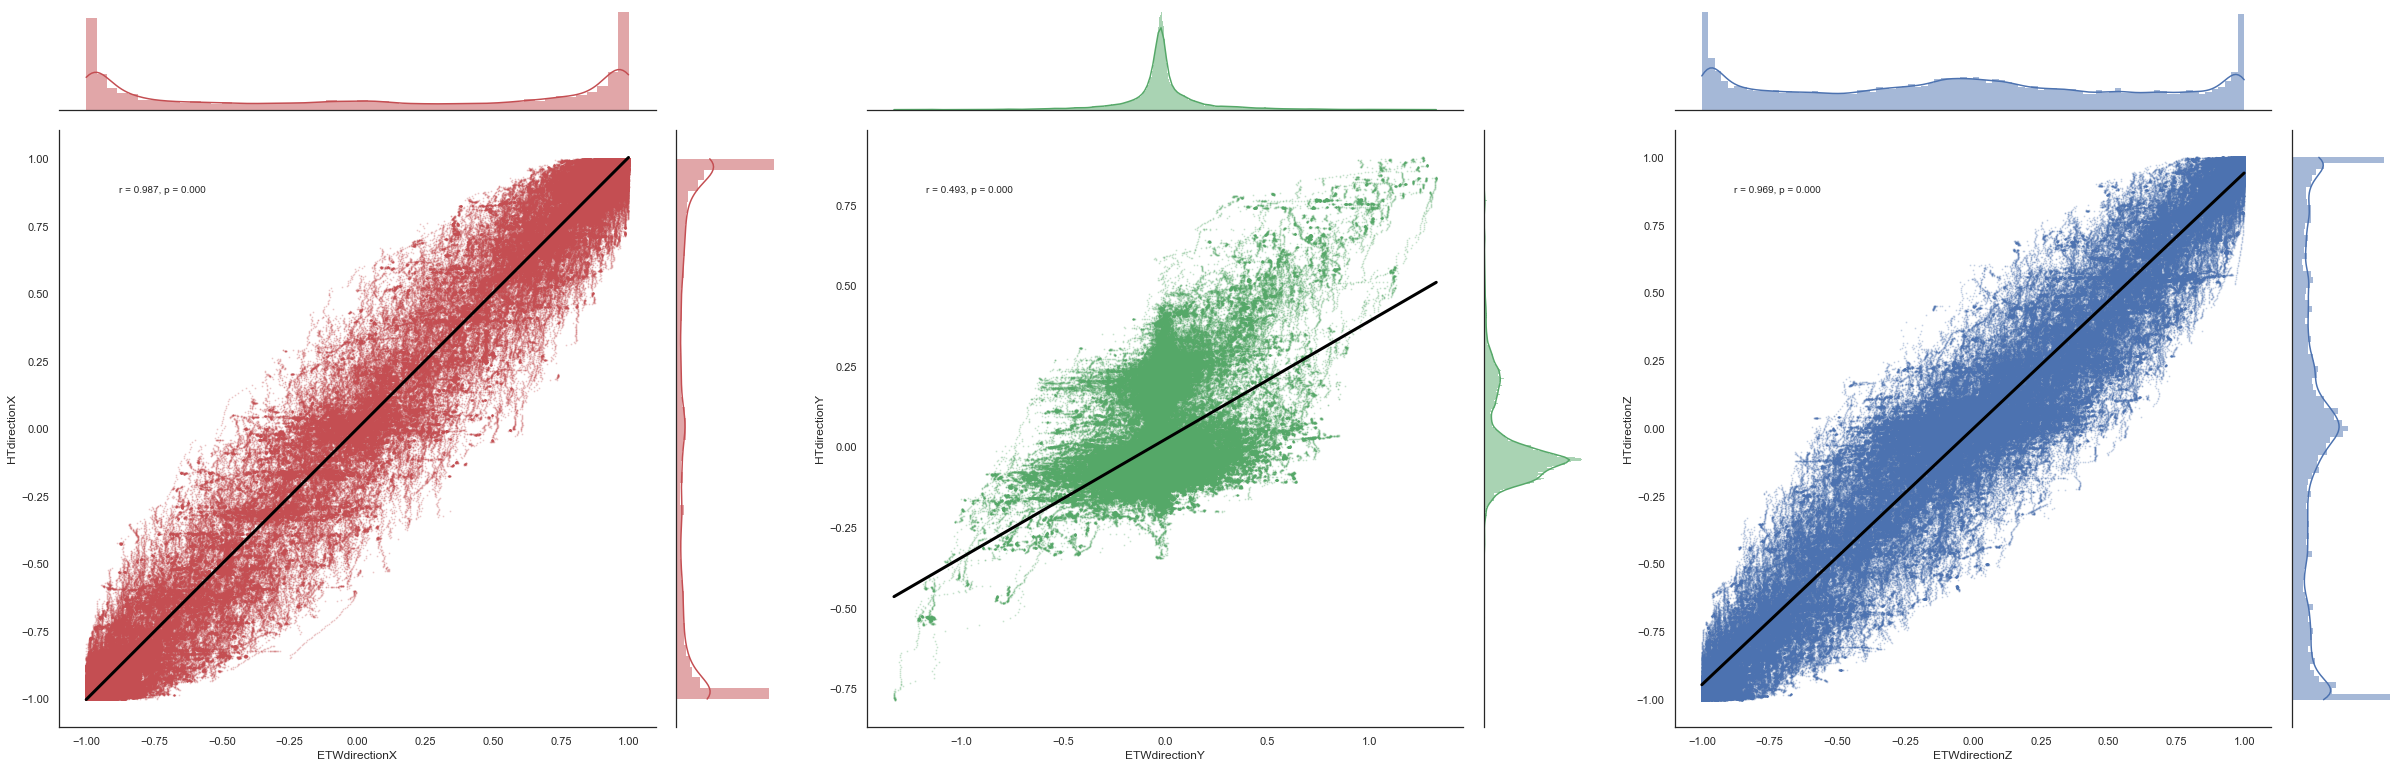

In [864]:
import patchworklib as pw
# For shared axes; ssee documentation on https: //pypi.org/project/patchworklib/
# sns.set_theme(style="white")
pw.overwrite_axisgrid()

# X-axis grid
g0 = dir_x = sns.jointplot(x='ETWdirectionX', y='HTdirectionX',data=df_origins,kind='reg', color=colors[3],scatter_kws={'alpha':0.2,'s': 1},line_kws={"color": "black","lw":3})
r_x, p_x = corr_coefficient(df_origins, x='ETWdirectionX', y='HTdirectionX')
annotate_rp(dir_x, r_x,p_x)
g0 = pw.load_seaborngrid(g0,figsize=(10,10))

# Y-axis grid
g1 = dir_y = sns.jointplot(x='ETWdirectionY', y='HTdirectionY',data=df_origins, kind='reg', color=colors[2],scatter_kws={'alpha':0.2,'s': 1},line_kws={"color": "black","lw":3})
r_y, p_y = corr_coefficient(df_origins, x='ETWdirectionY', y='HTdirectionY')
annotate_rp(dir_y, r_y, p_y)
g1 = pw.load_seaborngrid(g1,figsize=(10,10))

# Z-axis grid
g2 = dir_z = sns.jointplot(x='ETWdirectionZ', y='HTdirectionZ',data=df_origins, kind='reg', color=colors[0],scatter_kws={'alpha':0.2,'s': 1},line_kws={"color": "black","lw":3})
r_z, p_z = corr_coefficient(df_origins, x='ETWdirectionZ', y='HTdirectionZ')
annotate_rp(dir_z, r_z, p_z)
g2 = pw.load_seaborngrid(g2,figsize=(10,10))

((g0|g1|g2)).savefig()

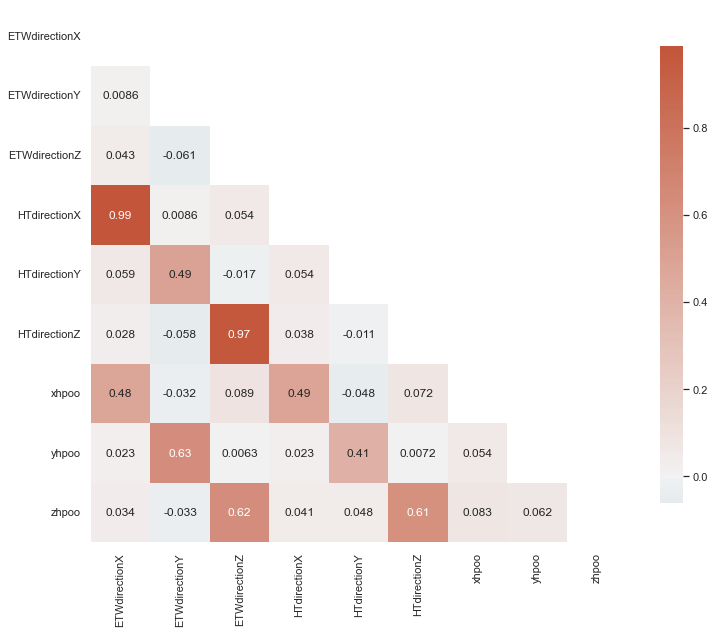

In [648]:
# ET and HT axis correlation heatmap
corr4 = df_origins[['ETWdirectionX','ETWdirectionY','ETWdirectionZ','HTdirectionX','HTdirectionY','HTdirectionZ', 'xhpoo', 'yhpoo', 'zhpoo']].corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr4, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(corr4, mask=mask, cmap=cmap, center=0,
            square=True, annot=True, ax=ax, cbar_kws={"shrink": .7})
plt.show()
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 3.3 Calculating power spectral density

In [888]:
def cal_psd(sig):
    """ Calculates the power spectral density (PSD) of a given signal using the Welch method
    Returns: 2D array containing the freq and psd of the signal"""
    f, psd = signal.welch(sig, fs=90, window='hamming')
    return f, psd

In [891]:
df_e_h = df_origins[['ETWdirectionX','ETWdirectionY','ETWdirectionY','HTdirectionX','HTdirectionY','HTdirectionZ']]


In [897]:
e_h_axes = ['ETWdirectionX','ETWdirectionY','ETWdirectionY','HTdirectionX','HTdirectionY','HTdirectionZ']

['ETWdirectionX_csd','ETWdirectionY_csd','ETWdirectionY_csd','HTdirectionX_csd','HTdirectionY_csd','HTdirectionZ_csd', 'ETWdirectionX_frq','ETWdirectionY_frq','ETWdirectionY_frq','HTdirectionX_frq','HTdirectionY_frq','HTdirectionZ_frq', 'filename']


# visualize all files individually
for file in tqdm(all_filenames):
    fileID = file.split('.')
    print(f"Visualizing ID: " + fileID[0])
    df = pd.read_csv(file)
    df_clean = rename_clean(df)
    df_csd = np.array()

    for col in df_clean.columns:
        if col in e_h_axes:
            frq, csd = signal.welch(df_clean[col], fs=90, window='hamming')




  0%|          | 0/4 [00:00<?, ?it/s]

Visualizing ID: correTS_c924cc42-5987-4025-b026-c672e304599f
Visualizing ID: correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c
Visualizing ID: correTS_1dea5bd2-80d1-4068-b512-99c55f85f44c
Visualizing ID: correTS_02715e7a-5a68-471b-9e63-f056c5f0df81


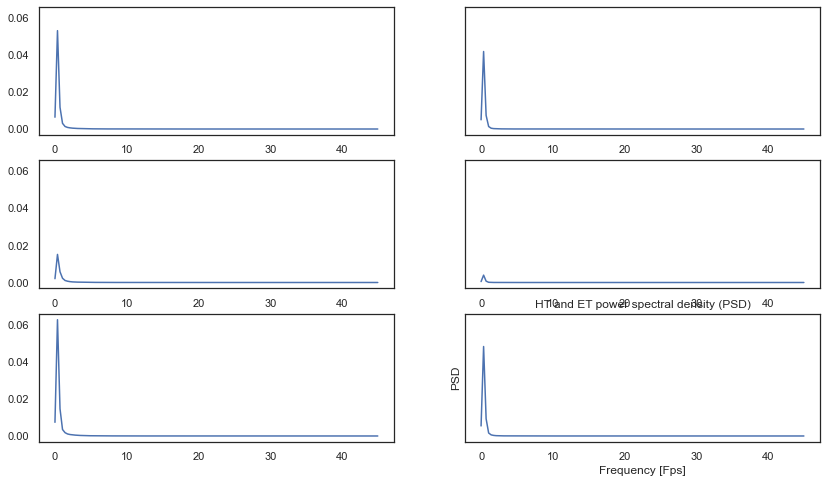

In [899]:
fig, ax = plt.subplots(3,2, figsize=(14,8), sharey=True)

f_e_x, Pxx_den_e_x = signal.welch(df_origins['ETWdirectionX'][120000:300000], fs=90, window='hamming')
f_e_y, Pxx_den_e_y = signal.welch(df_origins['ETWdirectionY'][120000:300000], fs=90, window='hamming')
f_e_z, Pxx_den_e_z = signal.welch(df_origins['ETWdirectionZ'][120000:300000], fs=90, window='hamming')


f_h_x, Pxx_den_h_x = signal.welch(df_origins['HTdirectionX'][120000:300000], fs=90,window='hamming')
f_h_y, Pxx_den_h_y = signal.welch(df_origins['HTdirectionY'][120000:300000], fs=90,window='hamming')
f_h_z, Pxx_den_h_z = signal.welch(df_origins['HTdirectionZ'][120000:300000], fs=90,window='hamming')

sns.lineplot(f_e_x, Pxx_den_e_x, ax=ax[0,0])
ax[1,0].plot(f_e_y, Pxx_den_e_y)
ax[2,0].plot(f_e_z, Pxx_den_e_z)

ax[0,1].plot(f_h_x, Pxx_den_h_x)
ax[1,1].plot(f_h_y, Pxx_den_h_y)
ax[2,1].plot(f_h_z, Pxx_den_h_z)

# ax[0,0].set_ylim(0,0.08)

plt.title('HT and ET power spectral density (PSD)')
plt.xlabel('Frequency [Fps]')
plt.ylabel('PSD')
plt.show()

In [ ]:
# visualize all files individually
for file in tqdm(all_filenames):
    fileID = file.split('.')
    print(f"Visualizing ID: " + fileID[0])
    df = pd.read_csv(file)
    df_clean = rename_clean(df)
    eye_x = np.array(df_origins['ETWdirectionX'])
    head_x = np.array(df_origins['HTdirectionX'])


### 3.4 Calculating Coherence
We can calculate the cross spectral density (CSD) and coherence (i.e., normalized CSD) between the eye and head coordinates to determine the relationship over time.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


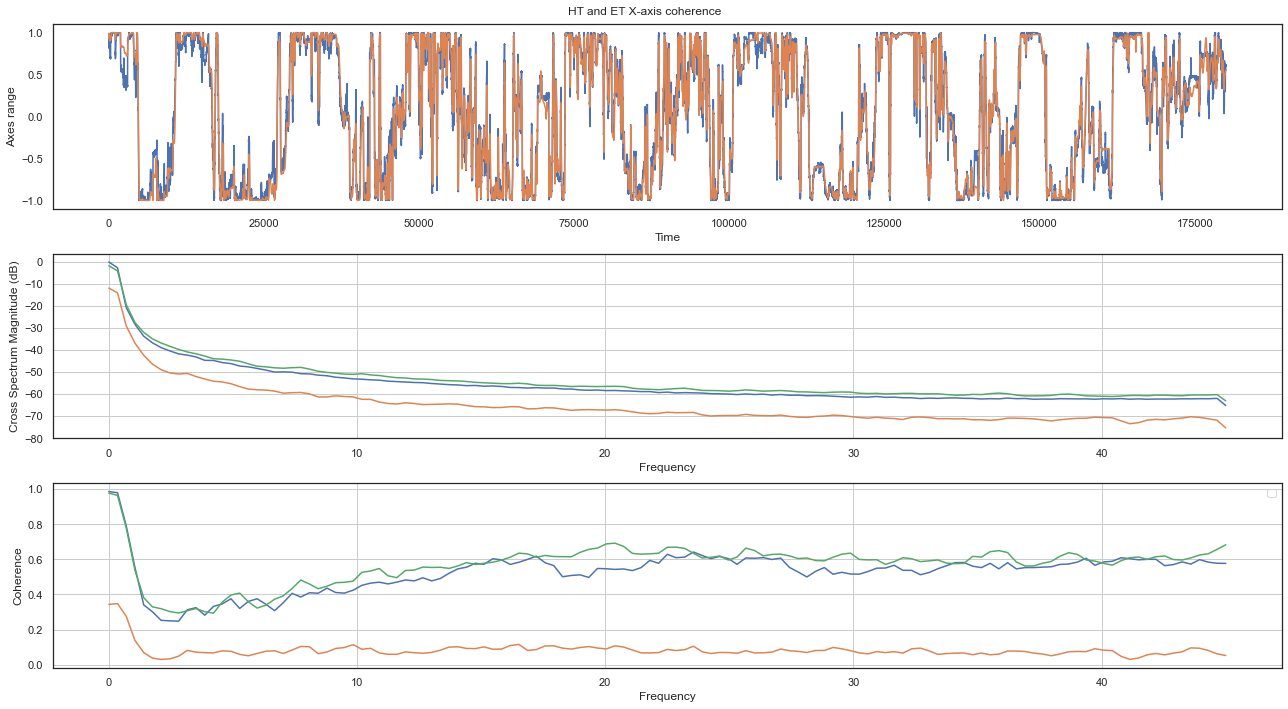

In [805]:
# Following documentation on https: //matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.cohere.html
# https: //matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html

fig, ax = plt.subplots(3,1,figsize=(18, 10))
plt.suptitle("HT and ET X-axis coherence")
# signal 1
eye_x = np.array(df_origins['ETWdirectionX'][120000:300000])
eye_y = np.array(df_origins['ETWdirectionY'][120000:300000])
eye_z = np.array(df_origins['ETWdirectionZ'][120000:300000])

ax[0].plot(eye_x)
# signal 2
head_x = np.array(df_origins['HTdirectionX'][120000:300000])
head_y = np.array(df_origins['HTdirectionY'][120000:300000])
head_z = np.array(df_origins['HTdirectionZ'][120000:300000])


ax[0].plot(head_x)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Axes range')

# cross spectral density (CSD) by Welch's average periodogram method
Pxy_x, freq_csd_x = ax[1].csd(head_x, eye_x, Fs=90)
Pxy_y, freq_csd_y = ax[1].csd(head_y, eye_y, Fs=90)
Pxy_z, freq_csd_z = ax[1].csd(head_z, eye_z, Fs=90)

# coherence
cxy_x, freq_x = ax[2].cohere(head_x, eye_x, Fs=90)

cxy_y, freq_y = ax[2].cohere(head_y, eye_y, Fs=90)

cxy_z, freq_z = ax[2].cohere(head_z, eye_z, Fs=90)


plt.legend(loc="upper right")

plt.tight_layout()
# plot the coherence graph
plt.show()

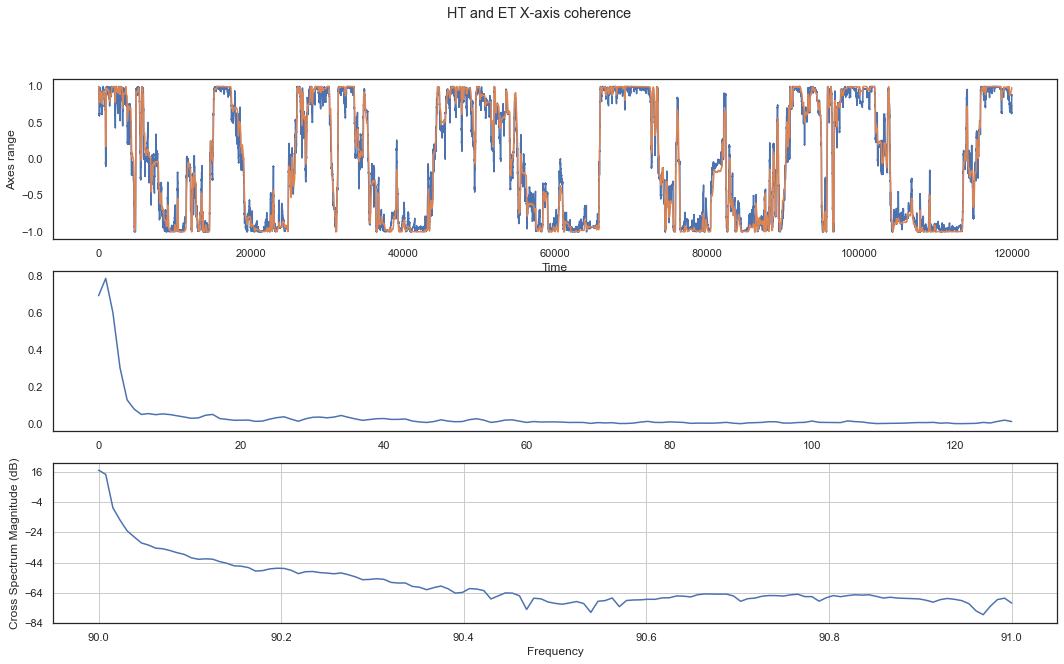

In [747]:
fig, ax = plt.subplots(3,1,figsize=(18, 10))
plt.suptitle("HT and ET X-axis coherence")
# signal 1
eye_x = np.array(df_origins['ETWdirectionX'].head(120000))
ax[0].plot(eye_x)
# signal 2
head_x= np.array(df_origins['HTdirectionX'].head(120000))
ax[0].plot(head_x)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Axes range')

# correlation
cxy, freq = signal.coherence(head_x, eye_x, fs=90)

ax[1].plot(freq)

ax[2].csd(eye_x,head_x, Fc=90)
# print(freq)
# freq
# plot the coherence graph
plt.show()

### 4. ET vs. HT behavior during gaze events
__TODO:__
- Once all colums are correct, excluse "long_events".

In [322]:
# Identify valid gazes
df['gaze'] = np.where((~df["isFix"].isnull()) & (~df["names"].isnull()),1,0)
# select only columns of interest
df_selected = df[['ETWoriginX', 'ETWoriginY', 'ETWoriginZ','ETWdirectionX','ETWdirectionY', 'ETWdirectionZ','HToriginX','HToriginY', 'HToriginZ', 'HTdirectionX', 'HTdirectionY', 'HTdirectionZ', 'xhpoo', 'yhpoo', 'zhpoo', 'names', 'time', 'gaze']]

# gaze = df[~df["names"].isnull()] # just to make sure you don't have a nan
# gaze = df[~df["long_events"].isnull()] # get rid of events that are too long

# define the types of gaze events
all_gazes = df_selected.loc[(df_selected['gaze']==1)]
# select faces gazes
face_gazes = df_selected.loc[(df_selected['gaze']==1) & (df_selected['names'].str.contains('face', regex=True, na=False))]
# select body gazes
body_gazes = df_selected.loc[(df_selected['gaze']==1) & (df_selected['names'].str.contains('NPC', regex=True, na=False))]
# select object gazes
object_gazes = df_selected.loc[(df_selected['gaze']==1) & ~(df_selected['names'].str.contains('NPC|face', regex=True, na=False) )]

In [323]:
all_gazes

ETWoriginX  ETWoriginY  ETWoriginZ  ETWdirectionX  ETWdirectionY  \
1        548.96930    2.159502   589.10960       0.999445      -0.041306   
2        548.99414    2.159547   589.10960       0.999470      -0.040301   
3        549.01850    2.159583   589.10986       0.999484      -0.039621   
4        549.04280    2.159638   589.11170       0.999510      -0.038649   
5        549.06710    2.159651   589.11430       0.999500      -0.039214   
...            ...         ...         ...            ...            ...   
612705   572.71857    2.037549   601.36975       0.148591       0.405098   
612706   572.71893    2.037536   601.36993       0.146431       0.405476   
612707   572.71910    2.037468   601.37006       0.146868       0.405077   
612708   572.71930    2.037517   601.37020       0.145807       0.405062   
612709   572.71936    2.037582   601.37024       0.144990       0.405665   

        ETWdirectionZ   HToriginX  HToriginY   HToriginZ  HTdirectionX  \
1            0.012150  549.004150   2.157337  589.090698      0.990777   
2            0.011573  549.028076   2.157340  589.093384      0.990821   
3            0.011871  549.052246   2.157314  589.096008      0.990827   
4            0.011454  549.076538   2.157311  589.098572      0.990861   
5            0.010948  549.100525   2.157320  589.101196      0.990871   
...               ...         ...        ...         ...           ...   
612705      -0.941544  572.712708   2.033466  601.352356      0.447026   
612706      -0.941789  572.712769   2.033489  601.352417      0.446806   
612707      -0.941818  572.712769   2.033375  601.352539      0.446490   
612708      -0.941987  572.712769   2.033409  601.352600      0.446164   
612709      -0.941967  572.712830   2.033363  601.352661      0.445802   

        HTdirectionY  HTdirectionZ       xhpoo     yhpoo       zhpoo  \
1          -0.078035      0.110775  570.891174  1.253504  589.376099   
2          -0.078090      0.110343  570.840271  1.278653  589.362549   
3          -0.078251      0.110175  570.853394  1.294013  589.369202   
4          -0.078282      0.109845  570.831665  1.317100  589.361389   
5          -0.078557      0.109562  570.813293  1.306465  589.352539   
...              ...           ...         ...       ...         ...   
612705     -0.094200     -0.889548  575.041626  8.370811  586.649780   
612706     -0.094164     -0.889661  575.007629  8.375134  586.649780   
612707     -0.094314     -0.889804  575.014587  8.368691  586.649780   
612708     -0.094540     -0.889944  574.997803  8.367414  586.649780   
612709     -0.094601     -0.890119  574.985168  8.377060  586.649780   

                    names      time  gaze  
1       Sitting_NPC (424)     0.011     1  
2       Sitting_NPC (424)     0.022     1  
3       Sitting_NPC (424)     0.033     1  
4       Sitting_NPC (424)     0.044     1  
5       Sitting_NPC (424)     0.055     1  
...                   ...       ...   ...  
612705              Lod_1  2199.784     1  
612706              Lod_1  2199.795     1  
612707              Lod_1  2199.807     1  
612708              Lod_1  2199.818     1  
612709              Lod_1  2199.829     1  

[388968 rows x 18 columns]

#### 4.1 Calculating distances and angles between ET, Ht, and object vectors

In [324]:
# Useful functions to calculate angles and distances
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def euclidian_distance(v1, v2):
    return np.linalg.norm(np.array(v1)-np.array(v2))

def vectors_angles_distance(df):
    # Angle between head and eye given their direction
    df['head2eyeAngle'] = df.apply(lambda x: 180/math.pi * angle_between([x["HTdirectionX"], x["HTdirectionY"], x["HTdirectionZ"]], [x["ETWdirectionX"], x["ETWdirectionY"], x["ETWdirectionZ"]]), axis = 1)
    # calculate the vector between head and object given their positions by substracting them.
    # then we calculate the angle given the head's direction.
    df['head2objectAngle'] = df.apply(lambda x: 180/math.pi * angle_between([x["xhpoo"]-x["HToriginX"], x["yhpoo"]-x["HToriginY"], x["zhpoo"]-x["HToriginZ"]], [x["HTdirectionX"], x["HTdirectionY"], x["HTdirectionZ"]]), axis = 1)
    df['eye2objectAngle'] = df.apply(lambda x: 180/math.pi * angle_between([x["xhpoo"]-x["ETWoriginX"], x["yhpoo"]-x["ETWoriginY"], x["zhpoo"]-x["ETWoriginZ"]], [x["ETWdirectionX"], x["ETWdirectionY"], x["ETWdirectionZ"]]), axis = 1)
    df['distanceVector'] = df.apply(lambda x: euclidian_distance([x["HTdirectionX"], x["HTdirectionY"], x["HTdirectionZ"]], [x["ETWdirectionX"], x["ETWdirectionY"], x["ETWdirectionZ"]]), axis=1)
    return df

def event_related_fields(df):
    # Create event related data fields
    # Flagging beginning of gazes
    df['gazeStartBool'] = df['names'].shift(1) != df['names']
    # Label each gazes with a unique number
    df['gazeID'] = df.apply(lambda x: x.name if x['gazeStartBool'] else None, axis=1).fillna(method="ffill")
    # add head and eye start angles, and gaze start (world) time to each gaze data point
    df['head2objectAngleStart'] = df.apply(lambda x: x['head2objectAngle'] if x['gazeStartBool'] else None, axis=1).fillna(method="ffill")
    df['eye2objectAngleStart'] = df.apply(lambda x: x['eye2objectAngle']  if x['gazeStartBool'] else None, axis=1).fillna(method="ffill")
    df['vectorDistanceStart'] = df.apply(lambda x: x['distanceVector']  if x['gazeStartBool'] else None, axis=1).fillna(method="ffill")
    df['timeStart'] = df.apply(lambda x: x['time']  if x['gazeStartBool'] else None, axis=1).fillna(method="ffill")
    # calculate changes on head and eye angle through time for each gaze datapoint (each row)
    df['head2objectAngleDelta'] = df['head2objectAngle'] - df['head2objectAngleStart']
    df['eye2objectAngleDelta'] = df['eye2objectAngle'] - df['eye2objectAngleStart']
    df['vectorDistanceDelta'] = df['distanceVector'] - df['vectorDistanceStart']
    # calculate delta_time to align all gazes to start from zero
    df['timeDelta'] = df['time'] - df['timeStart']
    # group all gazes datapoints into specific 'buckets'.
    # no matter how long the gaze was, they all will be between the same
    df['timeDeltaBucket'] = df.groupby('gazeID')['timeDelta'].transform(lambda x: pd.qcut(x, 6, labels=range(1,7)))
    # drop unnecessary columns
    df.drop(['gazeStartBool', 'timeStart'], axis=1, inplace=True)
    return df

def mean_gaze_duration(df):
    # calculate the mean of each bucket so that per bucket in the gaze event we only have one number.
    viz_data = df.groupby(['gazeID', 'timeDeltaBucket']).agg({'eye2objectAngleDelta': 'mean','head2objectAngleDelta': 'mean', 'timeDelta': 'mean', 'vectorDistanceDelta': 'mean', 'names': 'first', 'head2objectAngleStart': 'first', 'head2objectAngle':'first'}).reset_index()
    viz_data['initialRotation'] = viz_data.apply(lambda x: '0 to <10' if x['head2objectAngleStart'] < 10 else ('>= 20+' if x['head2objectAngleStart'] >= 20 else '>=10 to <20'), axis=1)
    return viz_data

In [325]:
# define which gaze data to work with
angles_all_gazes = vectors_angles_distance(all_gazes)

In [326]:
gaze_events_all = event_related_fields(angles_all_gazes)
gaze_events_all

ETWoriginX  ETWoriginY  ETWoriginZ  ETWdirectionX  ETWdirectionY  \
1        548.96930    2.159502   589.10960       0.999445      -0.041306   
2        548.99414    2.159547   589.10960       0.999470      -0.040301   
3        549.01850    2.159583   589.10986       0.999484      -0.039621   
4        549.04280    2.159638   589.11170       0.999510      -0.038649   
5        549.06710    2.159651   589.11430       0.999500      -0.039214   
...            ...         ...         ...            ...            ...   
612705   572.71857    2.037549   601.36975       0.148591       0.405098   
612706   572.71893    2.037536   601.36993       0.146431       0.405476   
612707   572.71910    2.037468   601.37006       0.146868       0.405077   
612708   572.71930    2.037517   601.37020       0.145807       0.405062   
612709   572.71936    2.037582   601.37024       0.144990       0.405665   

        ETWdirectionZ   HToriginX  HToriginY   HToriginZ  HTdirectionX  ...  \
1            0.012150  549.004150   2.157337  589.090698      0.990777  ...   
2            0.011573  549.028076   2.157340  589.093384      0.990821  ...   
3            0.011871  549.052246   2.157314  589.096008      0.990827  ...   
4            0.011454  549.076538   2.157311  589.098572      0.990861  ...   
5            0.010948  549.100525   2.157320  589.101196      0.990871  ...   
...               ...         ...        ...         ...           ...  ...   
612705      -0.941544  572.712708   2.033466  601.352356      0.447026  ...   
612706      -0.941789  572.712769   2.033489  601.352417      0.446806  ...   
612707      -0.941818  572.712769   2.033375  601.352539      0.446490  ...   
612708      -0.941987  572.712769   2.033409  601.352600      0.446164  ...   
612709      -0.941967  572.712830   2.033363  601.352661      0.445802  ...   

        distanceVector    gazeID  head2objectAngleStart  eye2objectAngleStart  \
1             0.105599       1.0               6.005398              0.000001   
2             0.106106       1.0               6.005398              0.000001   
3             0.105976       1.0               6.005398              0.000001   
4             0.106425       1.0               6.005398              0.000001   
5             0.106523       1.0               6.005398              0.000001   
...                ...       ...                    ...                   ...   
612705        0.584009  612702.0              33.415572              0.000124   
612706        0.585306  612702.0              33.415572              0.000124   
612707        0.584696  612702.0              33.415572              0.000124   
612708        0.585256  612702.0              33.415572              0.000124   
612709        0.586039  612702.0              33.415572              0.000124   

        vectorDistanceStart head2objectAngleDelta  eye2objectAngleDelta  \
1                  0.105599              0.000000              0.000000   
2                  0.105599              0.035914              0.000004   
3                  0.105599              0.034449              0.000020   
4                  0.105599              0.062273              0.000033   
5                  0.105599              0.067734              0.000110   
...                     ...                   ...                   ...   
612705             0.585541             -0.118379             -0.000095   
612706             0.585541             -0.043859             -0.000053   
612707             0.585541             -0.078620             -0.000080   
612708             0.585541             -0.045926             -0.000062   
612709             0.585541             -0.001602             -0.000087   

        vectorDistanceDelta  timeDelta  timeDeltaBucket  
1                  0.000000      0.000                1  
2                  0.000507      0.011                1  
3                  0.000377      0.022                1  
4                  0.000826      0.033  

In [291]:
average_gaze_duration = mean_gaze_duration(gaze_events_all)
average_gaze_duration

gazeID timeDeltaBucket  eye2objectAngleDelta  head2objectAngleDelta  \
0           1.0               1              0.000033               0.040074   
1           1.0               2              0.000047               0.068362   
2           1.0               3              0.000045               0.057596   
3           1.0               4              0.000054               0.000233   
4           1.0               5              0.000030              -0.147703   
...         ...             ...                   ...                    ...   
62755  612702.0               2             -0.000010              -0.082944   
62756  612702.0               3             -0.000095              -0.118379   
62757  612702.0               4             -0.000053              -0.043859   
62758  612702.0               5             -0.000080              -0.078620   
62759  612702.0               6             -0.000074              -0.023764   

       timeDelta  vectorDistanceDelta              names  \
0         0.0220             0.000527  Sitting_NPC (424)   
1         0.0778             0.000978  Sitting_NPC (424)   
2         0.1330             0.000768  Sitting_NPC (424)   
3         0.1888            -0.000268  Sitting_NPC (424)   
4         0.2440            -0.002831  Sitting_NPC (424)   
...          ...                  ...                ...   
62755     0.0220            -0.000955              Lod_1   
62756     0.0330            -0.001532              Lod_1   
62757     0.0440            -0.000235              Lod_1   
62758     0.0560            -0.000844              Lod_1   
62759     0.0725             0.000107              Lod_1   

       head2objectAngleStart  head2objectAngle initialRotation  
0                   6.005398          6.005398        0 to <10  
1                   6.005398          6.091289        0 to <10  
2                   6.005398          6.070835        0 to <10  
3                   6.005398          6.056212        0 to <10  
4                   6.005398          5.938839        0 to <10  
...                      ...               ...             ...  
62755              33.415572         33.332628          >= 20+  
62756              33.415572         33.297193          >= 20+  
62757              33.415572         33.371713          >= 20+  
62758              33.415572         33.336952          >= 20+  
62759              33.415572         33.369646          >= 20+  

[62760 rows x 10 columns]

In [292]:
# create the gaze categories BODY, FACE, OBJECT
average_gaze_duration.loc[average_gaze_duration['names'].str.contains('face', regex=True, na=False), 'category'] = 'Face'
average_gaze_duration.loc[average_gaze_duration['names'].str.contains('NPC', regex=True, na=False), 'category'] = 'Body'
average_gaze_duration.loc[~average_gaze_duration['names'].str.contains('NPC|face', regex=True, na=False), 'category'] = 'Other'
average_gaze_duration

gazeID timeDeltaBucket  eye2objectAngleDelta  head2objectAngleDelta  \
0           1.0               1              0.000033               0.040074   
1           1.0               2              0.000047               0.068362   
2           1.0               3              0.000045               0.057596   
3           1.0               4              0.000054               0.000233   
4           1.0               5              0.000030              -0.147703   
...         ...             ...                   ...                    ...   
62755  612702.0               2             -0.000010              -0.082944   
62756  612702.0               3             -0.000095              -0.118379   
62757  612702.0               4             -0.000053              -0.043859   
62758  612702.0               5             -0.000080              -0.078620   
62759  612702.0               6             -0.000074              -0.023764   

       timeDelta  vectorDistanceDelta              names  \
0         0.0220             0.000527  Sitting_NPC (424)   
1         0.0778             0.000978  Sitting_NPC (424)   
2         0.1330             0.000768  Sitting_NPC (424)   
3         0.1888            -0.000268  Sitting_NPC (424)   
4         0.2440            -0.002831  Sitting_NPC (424)   
...          ...                  ...                ...   
62755     0.0220            -0.000955              Lod_1   
62756     0.0330            -0.001532              Lod_1   
62757     0.0440            -0.000235              Lod_1   
62758     0.0560            -0.000844              Lod_1   
62759     0.0725             0.000107              Lod_1   

       head2objectAngleStart  head2objectAngle initialRotation category  
0                   6.005398          6.005398        0 to <10     Body  
1                   6.005398          6.091289        0 to <10     Body  
2                   6.005398          6.070835        0 to <10     Body  
3                   6.005398          6.056212        0 to <10     Body  
4                   6.005398          5.938839        0 to <10     Body  
...                      ...               ...             ...      ...  
62755              33.415572         33.332628          >= 20+    Other  
62756              33.415572         33.297193          >= 20+    Other  
62757              33.415572         33.371713          >= 20+    Other  
62758              33.415572         33.336952          >= 20+    Other  
62759              33.415572         33.369646          >= 20+    Other  

[62760 rows x 11 columns]

### 4.2 Distances

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


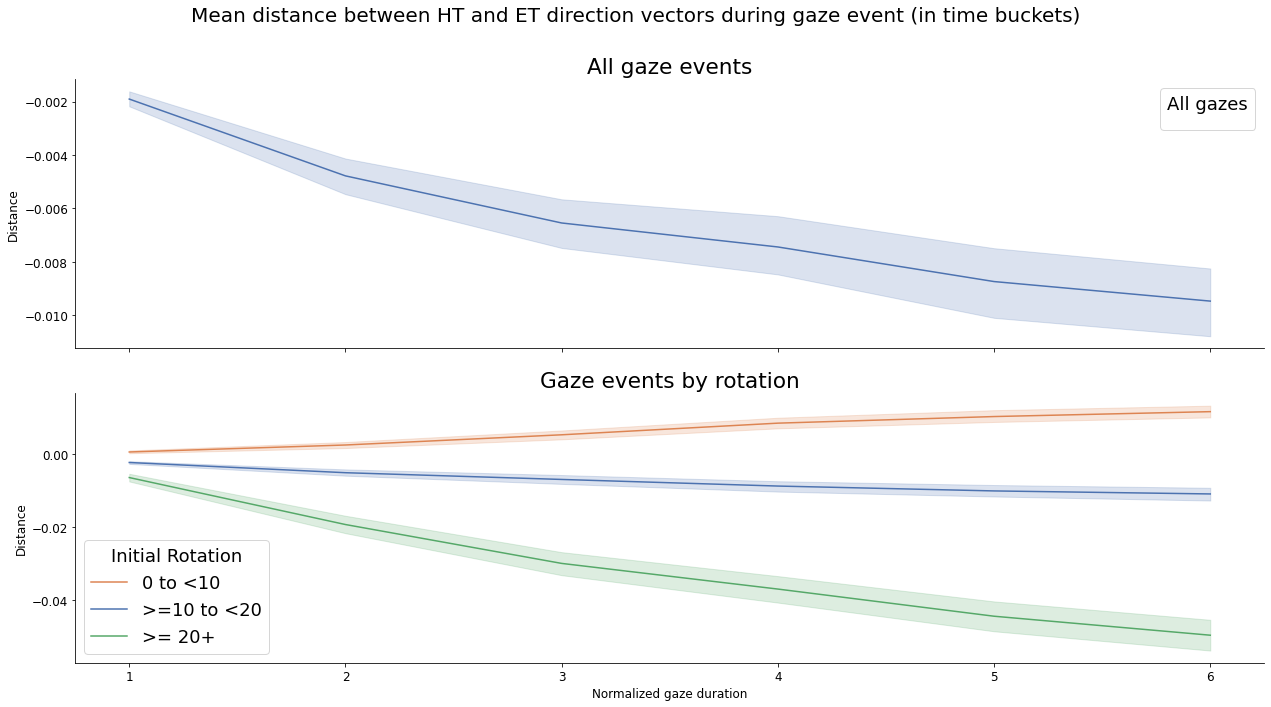

In [295]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
# sns.palplot(deep_pal)
# colors = {'>=10 to <20':colors[0], '0 to <10':colors[1], '>= 20+':colors[2]}

fig, ax = plt.subplots(2,1,figsize=(18, 10), sharex=True)
plt.rcParams.update({'font.size': 18})
fig.suptitle("Mean distance between HT and ET direction vectors during gaze event (in time buckets)", fontsize=20, y=0.99)
# visualize gaze event by distance between HT and YT vectors (in a normed sphere)
# all gaze events
g_all = sns.lineplot(x='timeDeltaBucket', y='vectorDistanceDelta', data=average_gaze_duration, palette=colors, ax=ax[0], legend=False)
ax[0].set_title('All gaze events')
ax[0].set_xlabel('Time (in delta buckets)')
ax[0].set_ylabel('Distance')
g_all.legend(title='All gazes')

# gaze events grouped by initial rotation
g_grouped = sns.lineplot(x='timeDeltaBucket', y='vectorDistanceDelta', data=average_gaze_duration,hue='initialRotation', palette=colors, ax=ax[1])
g_grouped.legend_.set_title('Initial Rotation')
sns.despine(top=True)
ax[1].set_title('Gaze events by rotation')
ax[1].set_xlabel('Normalized gaze duration')
ax[1].set_ylabel('Distance')
plt.tight_layout()

### 4.3 Rotations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


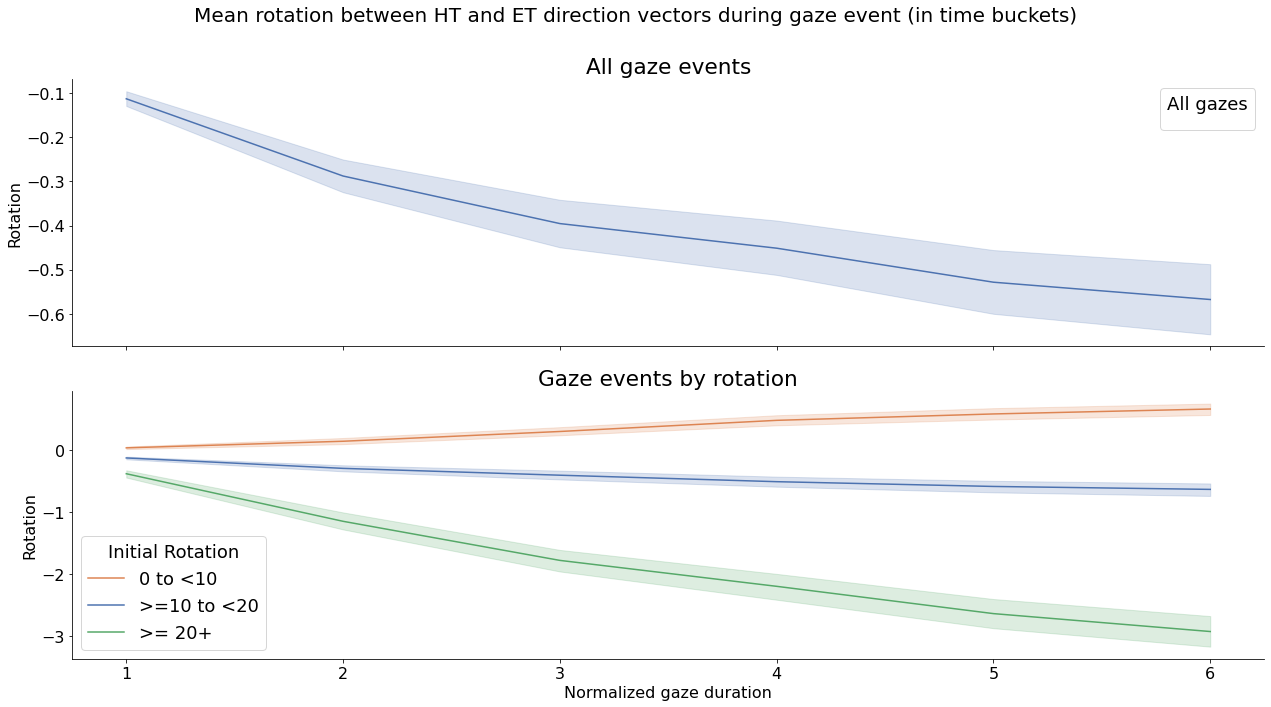

In [219]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
# sns.palplot(deep_pal)
colors = {'>=10 to <20':deep_pal[0], '0 to <10':deep_pal[1], '>= 20+':deep_pal[2]}

fig, ax = plt.subplots(2,1,figsize=(18, 10), sharex=True)
plt.rcParams.update({'font.size': 18})
fig.suptitle("Mean rotation between HT and ET direction vectors during gaze event (in time buckets)", fontsize=20, y=0.99)
# visualize gaze event by distance between HT and YT vectors (in a normed sphere)
# all gaze events
g_all = sns.lineplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration, palette=colors, ax=ax[0], legend=False)
ax[0].set_title('All gaze events')
ax[0].set_xlabel('Time (in delta buckets)')
ax[0].set_ylabel('Rotation')
g_all.legend(title='All gazes')

# gaze events grouped by initial rotation
g_grouped = sns.lineplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration,hue='initialRotation', palette=colors, ax=ax[1])
g_grouped.legend_.set_title('Initial Rotation')
sns.despine(top=True)
ax[1].set_title('Gaze events by rotation')
ax[1].set_xlabel('Normalized gaze duration')
ax[1].set_ylabel('Rotation')
plt.tight_layout()

### 4.4 Changes in rotations per category

__NOTE__
- We must endure they all have the same amount of gazes. So far, it is unknown how many faces, bodies, and background gazes are included

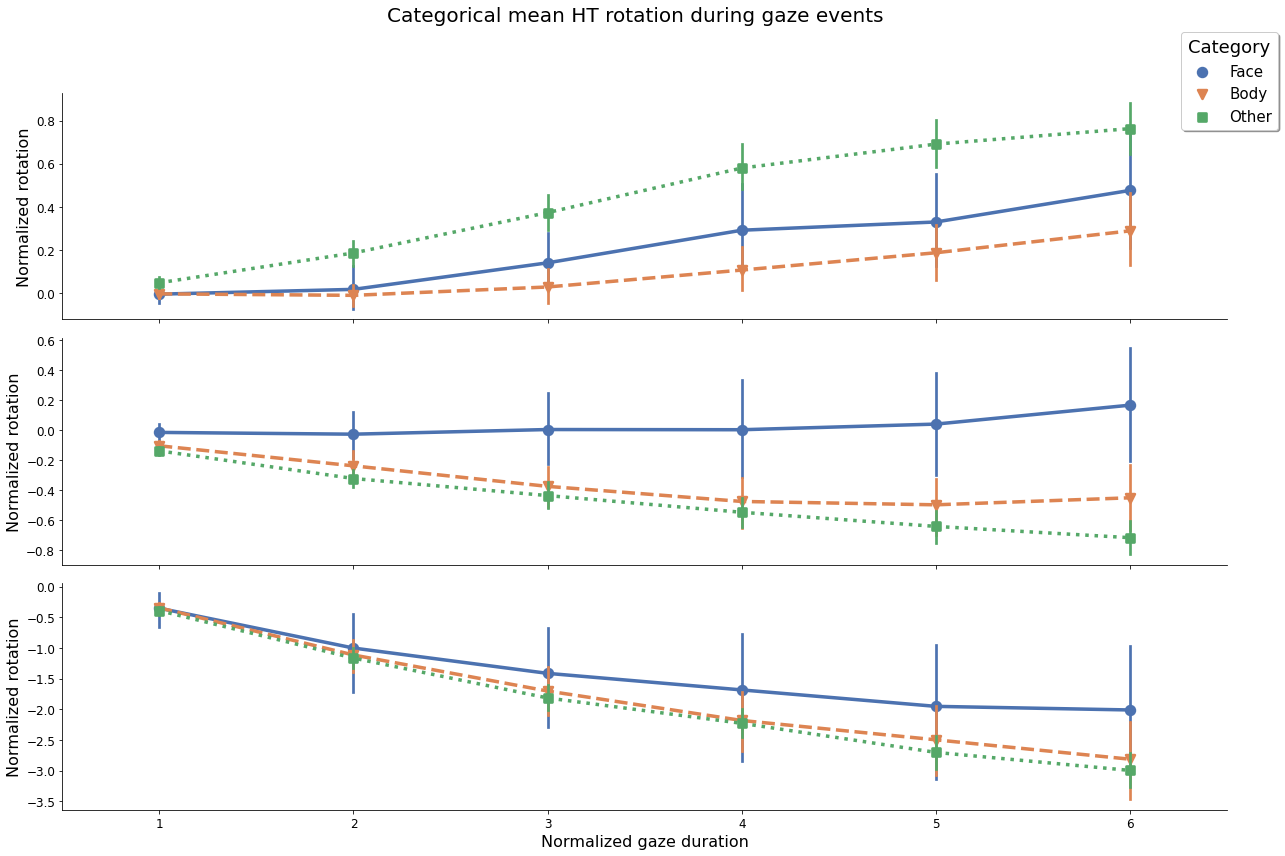

In [282]:
fig, ax = plt.subplots(3,1,figsize=(18, 12), sharex=True)
plt.rcParams.update({'font.size': 12})
fig.suptitle("Categorical mean HT rotation during gaze events", fontsize=20, y=0.99)

hue_order = ['Face', 'Body', 'Other']
for index, rotation in enumerate(average_gaze_duration['initialRotation'].unique()):
    p1 = sns.pointplot( data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation],x='timeDeltaBucket', y='head2objectAngleDelta', hue='category', hue_order=hue_order, legend=False,ax=ax[index], markers=['o','v','s'], scale=1.3, linestyles=["-","--",':'])
    # sns.stripplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation], size=7, color='black', ax=ax[index], alpha=0.2)
    # sns.swarmplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation].sample(2000), color='black',size=3, ax=ax[index])
    ax[index].set_ylabel('Normalized rotation', fontsize=16)
    p1.legend(fontsize = 15, \
               bbox_to_anchor= (1.05, 1.3), \
               title="Category", \
               title_fontsize = 18, \
               shadow = True, \
               facecolor = 'white');
    if index >= 1:
        p1.get_legend().remove()
    if index == 2:
        ax[index].set_xlabel('Normalized gaze duration',fontsize=16)
    else:
        ax[index].set_xlabel('')
sns.despine(top=True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 77.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/Defa

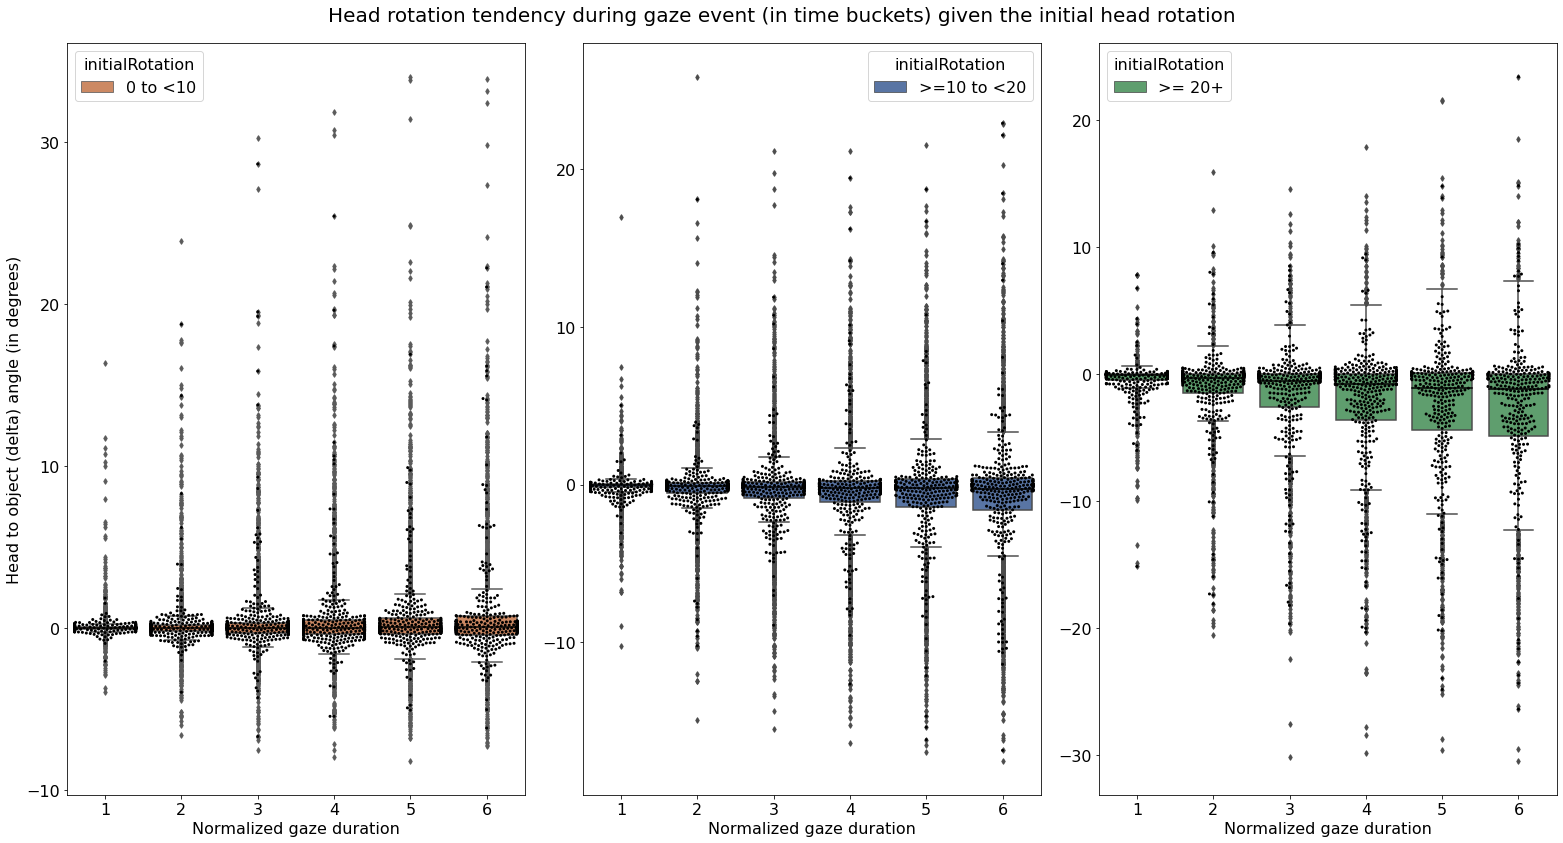

In [199]:
fig, ax = plt.subplots(1,3, figsize=(22,12))
plt.rcParams.update({'font.size': 16})

fig.suptitle("Head rotation tendency during gaze event (in time buckets) given the initial head rotation", fontsize=20, y=0.98)

for index, rotation in enumerate(average_gaze_duration['initialRotation'].unique()):
    p1 = sns.boxplot( data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation],x='timeDeltaBucket', y='head2objectAngleDelta', hue='initialRotation',palette=colors, medianprops={'color': 'black'}, fliersize = 4, ax=ax[index])
    # sns.stripplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation], size=7, color='black', ax=ax[index], alpha=0.2)
    sns.swarmplot(x='timeDeltaBucket', y='head2objectAngleDelta', data=average_gaze_duration[average_gaze_duration['initialRotation'] == rotation].sample(2000), color='black',size=3, ax=ax[index])
    ax[index].set_xlabel('Normalized gaze duration')
    if index == 0:
        ax[index].set_ylabel('Head to object (delta) angle (in degrees)')
    else:
        ax[index].set_ylabel('')
plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='count'>

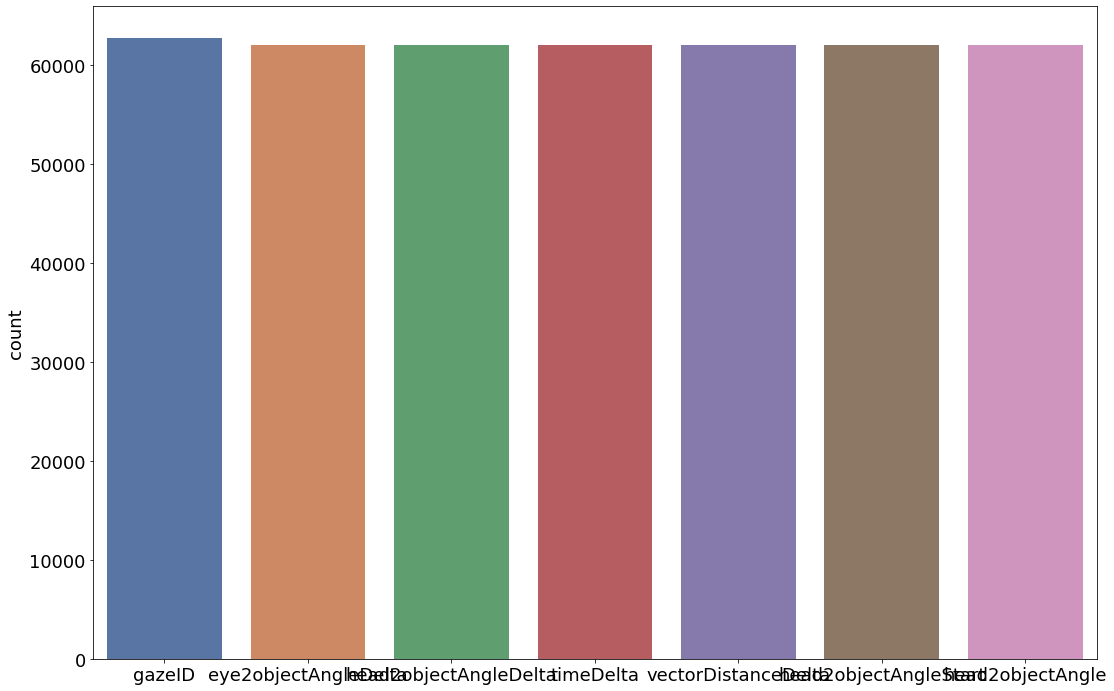

In [321]:
fig, ax = plt.subplots(1,1,figsize=(18, 12))

sns.countplot(data=average_gaze_duration)